In [117]:
import os
import logging, timeit
#from btEngine2.DataLoader import DataLoader
from btEngine2.MarketData import MarketData
from btEngine2.TradingRule import TradingRule
import matplotlib.pyplot as plt


import platform
import pandas as pd

pd.options.display.float_format = lambda x: f'{x:,.0f}' if abs(x) >= 1000 else (f'{x:.2f}' if abs(x) < 10 else f'{x:.1f}')
pd.set_option('future.no_silent_downcasting', True)


# Detect operating system
if platform.system() == "Windows":
    ticker_csv_path = r'G:\Projects\BackTesting1.0\Data\Inputs\TickerList-Futs.csv'
    save_directory = r"G:\Projects\BackTesting1.0\Data\Bloomberg\Futures"
    helper_directory = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles'
    bt_folder = r'BackTests\bo_resrch_ml_2'
    av_folder = r'G:\Projects\BackTesting1.0\Data\Inputs\AssetSizing-Futs.csv'
else:  # Assume macOS for other cases
    ticker_csv_path = r'Data/Inputs/TickerList-Futs.csv'
    save_directory = r"Data/Bloomberg/Futures"
    helper_directory = r'Data/Bloomberg/HelperFiles'
    bt_folder = r'BackTests/bo_resrch_ml_2'
    av_folder = r'Data/Inputs/AssetSizing-Futs.csv'



# Define paths to auxiliary data for MarketData
tick_values_path = os.path.join(helper_directory, 'fut_val_pt.parquet')
fx_rates_path = os.path.join(helper_directory, 'fxHist.parquet')

# Initialize the MarketData
market_data = MarketData(
    base_directory=save_directory,
    tick_values_path=tick_values_path,
    fx_rates_path=fx_rates_path,
    instrument_type="Futures",
    n_threads=8,  # Number of threads for parallel data loading
    log_level=logging.ERROR  # Set to DEBUG for more detailed logs
)


In [118]:
tick = 'BR1 Curncy'
# Access data for a specific ticker
try:
    test_df = market_data.get_ticker_data(tick)
    print(test_df)
except ValueError as e:
    print(e)

# Access all preprocessed data
all_data = market_data.get_data()
print(f"Total tickers loaded: {len(all_data)}")

# Access FX rates
fx_rates = market_data.get_fx_rates()
# Access tick values
tick_values = market_data.get_tick_values()
# Access asset classes
asset_classes = market_data.get_asset_classes()

test_df.to_pandas().to_clipboard()
#market_data = market_data.date_filter(start_date='01012010')

shape: (2_374, 14)
┌────────────┬────────┬────────┬────────┬───┬─────────┬─────────┬─────────────────┬────────────────┐
│ Date       ┆ Open   ┆ High   ┆ Low    ┆ … ┆ BadOHLC ┆ FX_Rate ┆ Tick_Value_Base ┆ Tick_Value_USD │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---     ┆ ---     ┆ ---             ┆ ---            │
│ date       ┆ f64    ┆ f64    ┆ f64    ┆   ┆ bool    ┆ f64     ┆ f64             ┆ f64            │
╞════════════╪════════╪════════╪════════╪═══╪═════════╪═════════╪═════════════════╪════════════════╡
│ 2015-07-01 ┆ 19.27  ┆ 19.295 ┆ 18.87  ┆ … ┆ false   ┆ 1.0     ┆ 1000.0          ┆ 1000.0         │
│ 2015-07-02 ┆ 18.98  ┆ 19.365 ┆ 18.95  ┆ … ┆ false   ┆ 1.0     ┆ 1000.0          ┆ 1000.0         │
│ 2015-07-06 ┆ 19.295 ┆ 19.03  ┆ 18.84  ┆ … ┆ false   ┆ 1.0     ┆ 1000.0          ┆ 1000.0         │
│ 2015-07-07 ┆ 18.585 ┆ 18.595 ┆ 18.375 ┆ … ┆ false   ┆ 1.0     ┆ 1000.0          ┆ 1000.0         │
│ 2015-07-08 ┆ 18.445 ┆ 18.445 ┆ 17.98  ┆ … ┆ false   ┆ 1.0     ┆ 1000.0

In [119]:

from btEngine2.Rules.Momentum.sbo_long import *
from btEngine2.Rules.Momentum.sbo_short import *


pSizeParamsUse = {
    'AssetVol': av_folder,  # Target asset volatility in USD
    'VolLookBack': 30,
    'VolMethod': 'ewm'  # Lookback period for volatility calculation
}

simple_slow_l = dict(X=60, N=8, r=0.85, atr_type='atr')
simple_slow_s = dict(X=60, N=8, r=0.85, atr_type='atr')

simple_fast_l = dict(X=21, N=4, r=0.65, atr_type='atr')
simple_fast_s = dict(X=21, N=4, r=0.65, atr_type='atr')

simple_slow_l_tf = dict(X=60, N=8, r=0.85, atr_type='atr', trend_filter=(100, 'ema'))
simple_slow_s_tf = dict(X=60, N=8, r=0.85, atr_type='atr', trend_filter=(100, 'ema'))

simple_fast_l_tf = dict(X=21, N=4, r=0.65, atr_type='atr', trend_filter=(100, 'ema'))
simple_fast_s_tf = dict(X=21, N=4, r=0.65, atr_type='atr', trend_filter=(100, 'ema'))

rsi_l = dict(rsi_param=(7, 90), N=6)
rsi_s = dict(rsi_param=(7, 10), N=6)


rsi_l_tf = dict(rsi_param=(7, 90), N=6, trend_filter=(100, 'ema'))
rsi_s_tf = dict(rsi_param=(7, 10), N=6, trend_filter=(100, 'ema'))

rsi_l_ml = dict(rsi_param=(7, 90), N=6, min_dps=5, max_dps=30, probability_threshold=0.65, trend_filter=(100, 'ema'))
rsi_s_ml = dict(rsi_param=(7, 10), N=6, min_dps=5, max_dps=30, probability_threshold=0.65, trend_filter=(100, 'ema'))


In [120]:
def get_variable_name(var, globals_dict):
    return [name for name in globals_dict if globals_dict[name] is var]


In [121]:

trading_rules_dict = {}

# Define the trading rule functions and their corresponding parameters
trading_rule_functions = {
    'rsi_l': (bo_rsi_long, [rsi_l, rsi_l_tf]),
    'rsi_s': (bo_rsi_short, [rsi_s, rsi_s_tf]),
    'rsi_l_ml': (bo_rsi_long_ml, [rsi_l_ml]),
    'rsi_s_ml': (bo_rsi_short_ml, [rsi_s_ml]),
    'sbo_l_slow': (sbo_long, [simple_slow_l, simple_fast_l, simple_slow_l_tf, simple_fast_l_tf]),
    'sbo_s_slow': (sbo_short, [simple_slow_s, simple_fast_s, simple_slow_s_tf, simple_fast_s_tf]),
}




# Loop through each trading rule function and its parameters
for rule_name, (rule_function, params_list) in trading_rule_functions.items():
    for params in params_list:
        print(params)
        print(f'name: {get_variable_name(params, globals())[0]}')
        rule_label = get_variable_name(params, globals())[0]
        print(rule_label)
        print('---------------------------------')

        trading_rules_dict[rule_label] = TradingRule(
            market_data=market_data,
            trading_rule_function=rule_function,
            trading_params=params,
            position_sizing_params=pSizeParamsUse,
            cont_rule=False,
            name_label=rule_label,
            bt_folder=bt_folder,
            log_level = logging.ERROR
        )

trading_rules_dict


{'rsi_param': (7, 90), 'N': 6}
name: rsi_l
rsi_l
---------------------------------
{'rsi_param': (7, 90), 'N': 6, 'trend_filter': (100, 'ema')}
name: rsi_l_tf
rsi_l_tf
---------------------------------
{'rsi_param': (7, 10), 'N': 6}
name: rsi_s
rsi_s
---------------------------------
{'rsi_param': (7, 10), 'N': 6, 'trend_filter': (100, 'ema')}
name: rsi_s_tf
rsi_s_tf
---------------------------------
{'rsi_param': (7, 90), 'N': 6, 'min_dps': 5, 'max_dps': 30, 'probability_threshold': 0.65, 'trend_filter': (100, 'ema')}
name: rsi_l_ml
rsi_l_ml
---------------------------------
{'rsi_param': (7, 10), 'N': 6, 'min_dps': 5, 'max_dps': 30, 'probability_threshold': 0.65, 'trend_filter': (100, 'ema')}
name: rsi_s_ml
rsi_s_ml
---------------------------------
{'X': 60, 'N': 8, 'r': 0.85, 'atr_type': 'atr'}
name: simple_slow_l
simple_slow_l
---------------------------------
{'X': 21, 'N': 4, 'r': 0.65, 'atr_type': 'atr'}
name: simple_fast_l
simple_fast_l
---------------------------------
{'X': 

{'rsi_l': <btEngine2.TradingRule.TradingRule at 0x3414a12b0>,
 'rsi_l_tf': <btEngine2.TradingRule.TradingRule at 0x10480a4e0>,
 'rsi_s': <btEngine2.TradingRule.TradingRule at 0x33f36d4c0>,
 'rsi_s_tf': <btEngine2.TradingRule.TradingRule at 0x33e9f7dd0>,
 'rsi_l_ml': <btEngine2.TradingRule.TradingRule at 0x33e9f64e0>,
 'rsi_s_ml': <btEngine2.TradingRule.TradingRule at 0x33e9f6f00>,
 'simple_slow_l': <btEngine2.TradingRule.TradingRule at 0x33e9f69c0>,
 'simple_fast_l': <btEngine2.TradingRule.TradingRule at 0x33e9f7f80>,
 'simple_slow_l_tf': <btEngine2.TradingRule.TradingRule at 0x33e9f7c20>,
 'simple_fast_l_tf': <btEngine2.TradingRule.TradingRule at 0x33e9f7b30>,
 'simple_slow_s': <btEngine2.TradingRule.TradingRule at 0x33e9f7ad0>,
 'simple_fast_s': <btEngine2.TradingRule.TradingRule at 0x33e9f7a10>,
 'simple_slow_s_tf': <btEngine2.TradingRule.TradingRule at 0x33e9f7860>,
 'simple_fast_s_tf': <btEngine2.TradingRule.TradingRule at 0x33e9f77a0>}

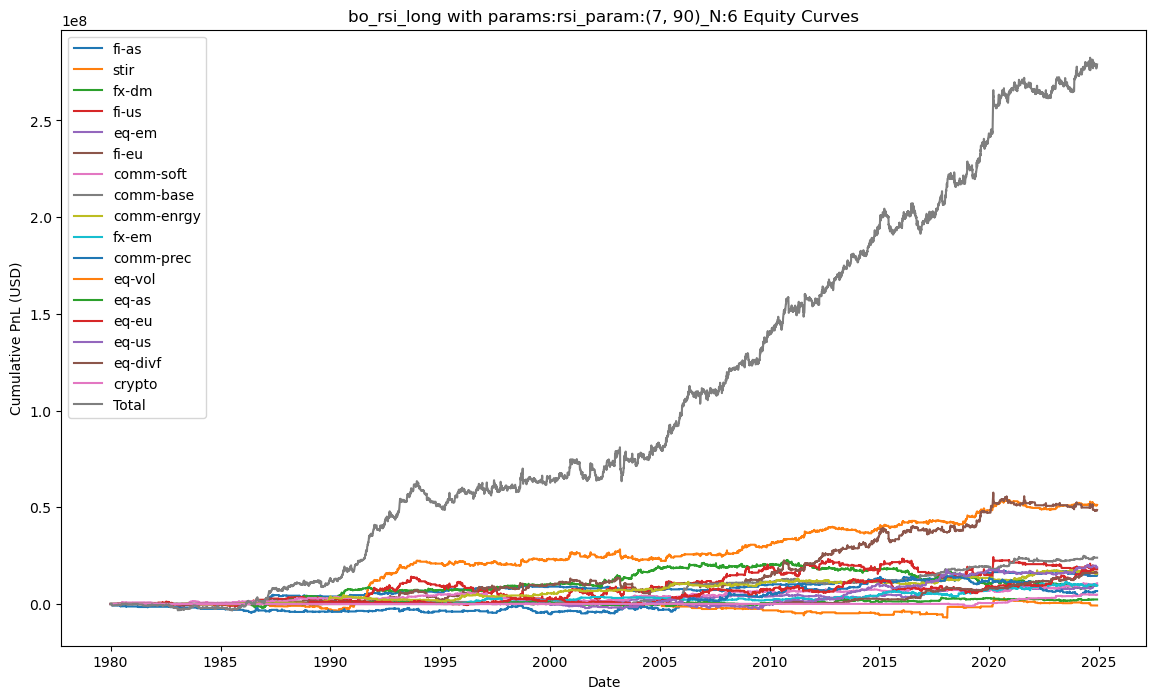

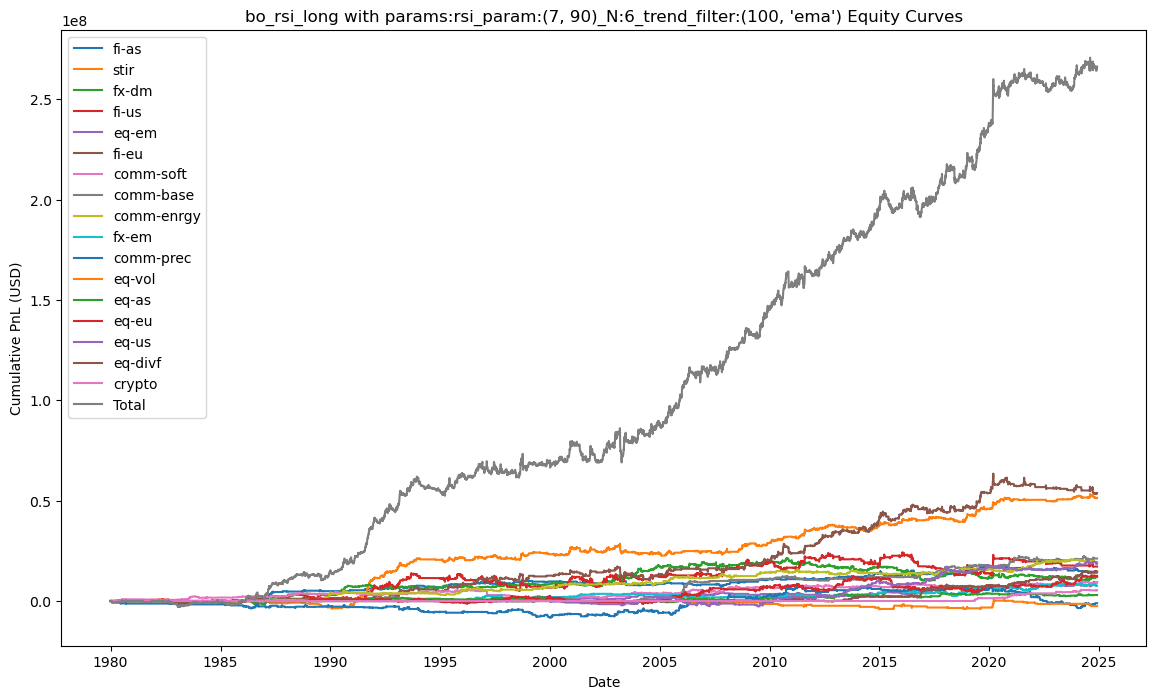

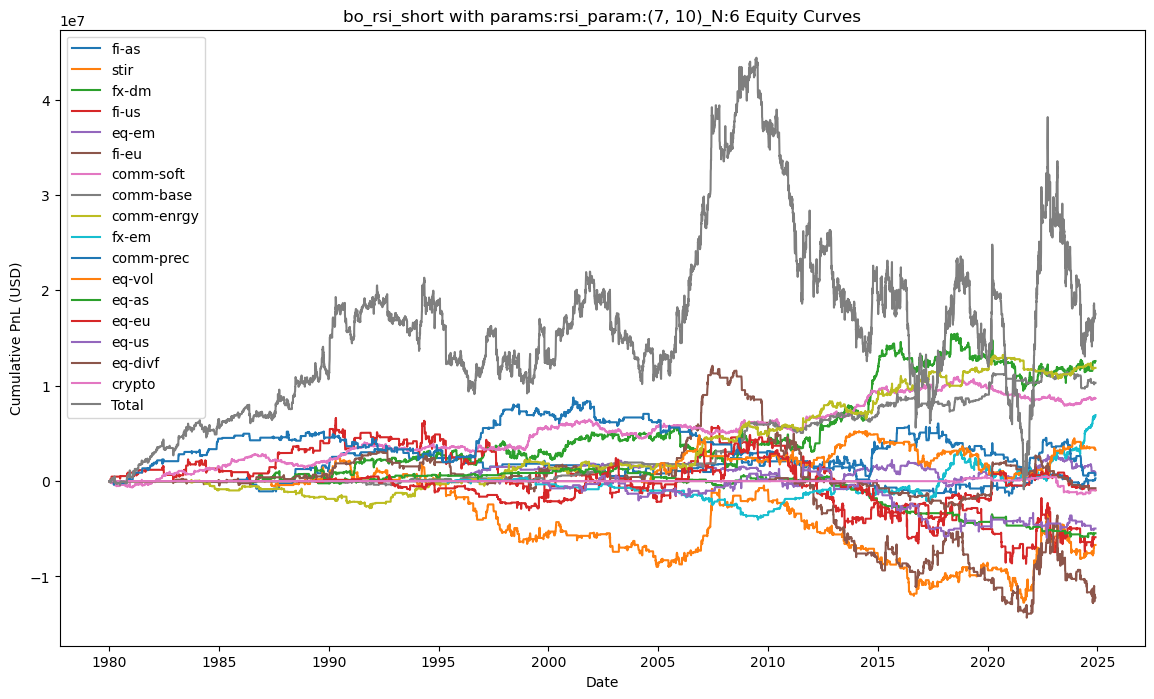

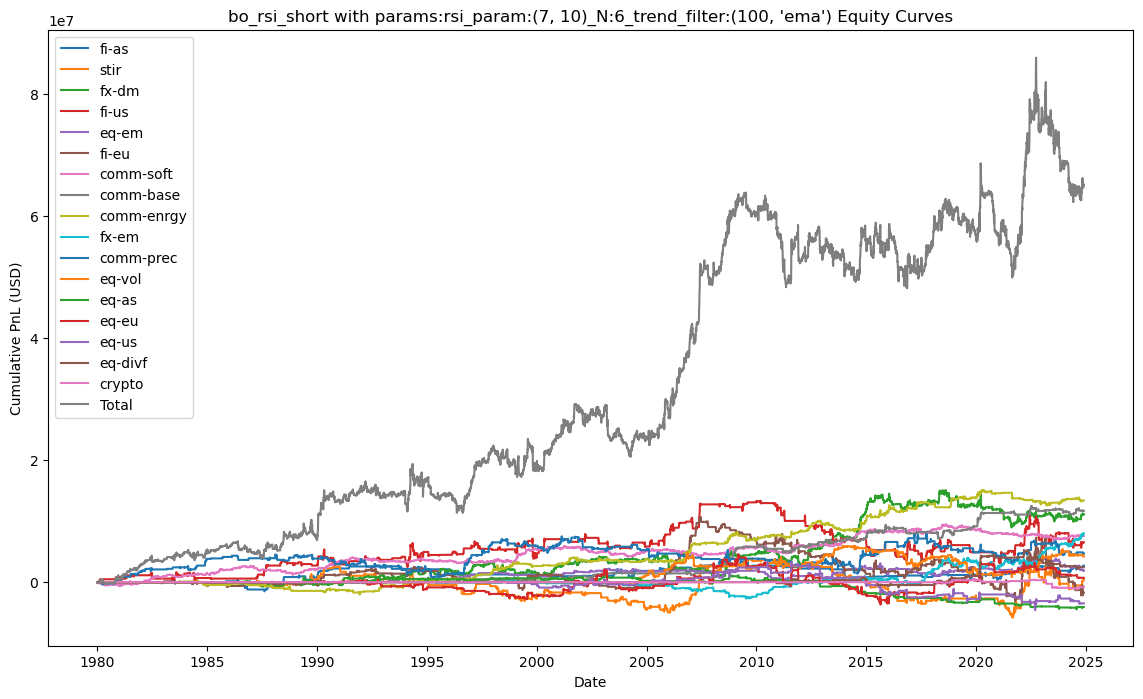

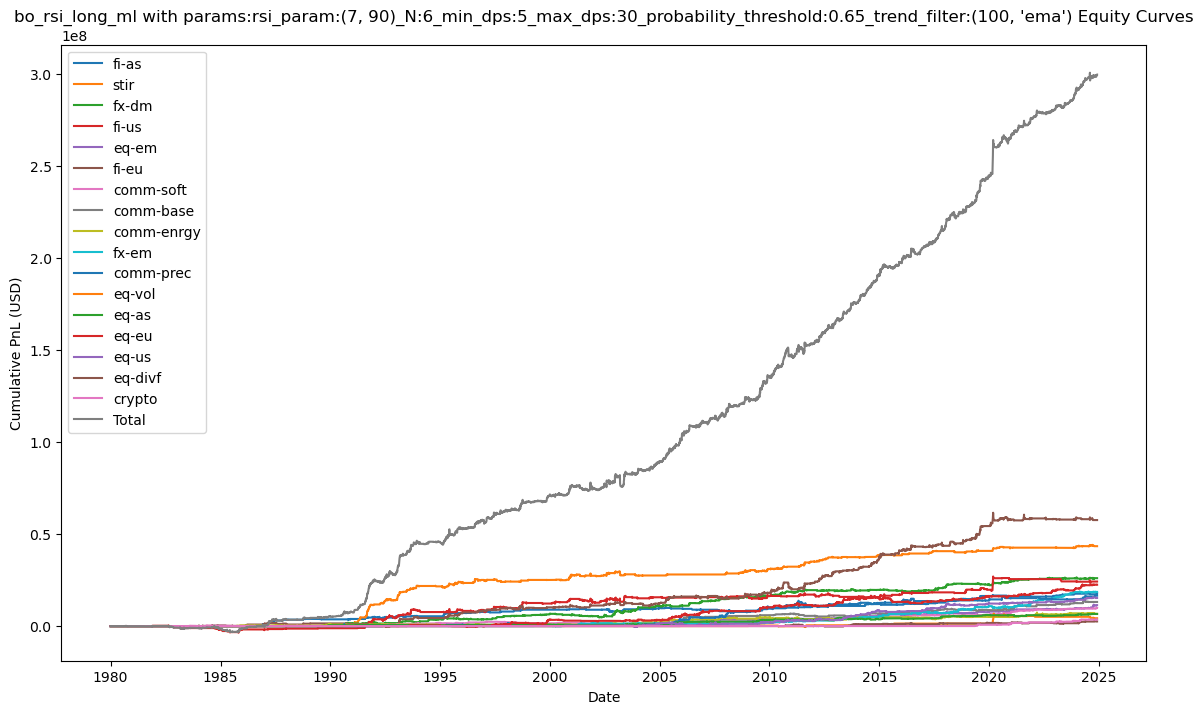

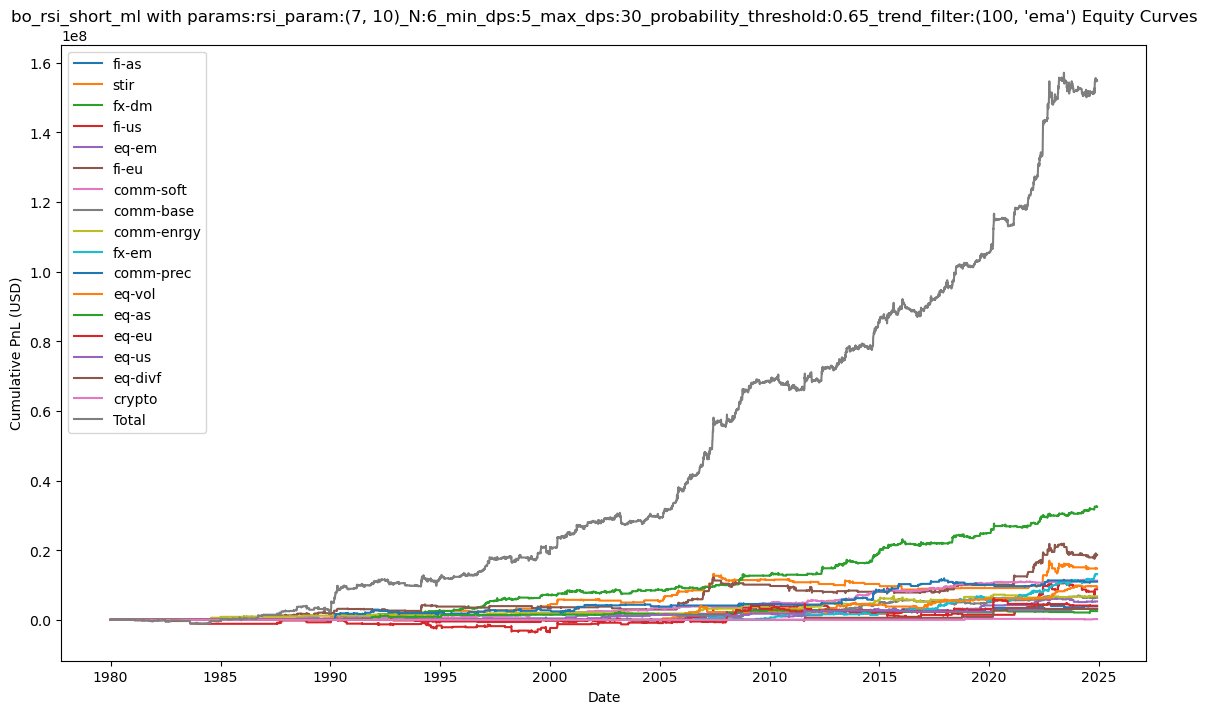

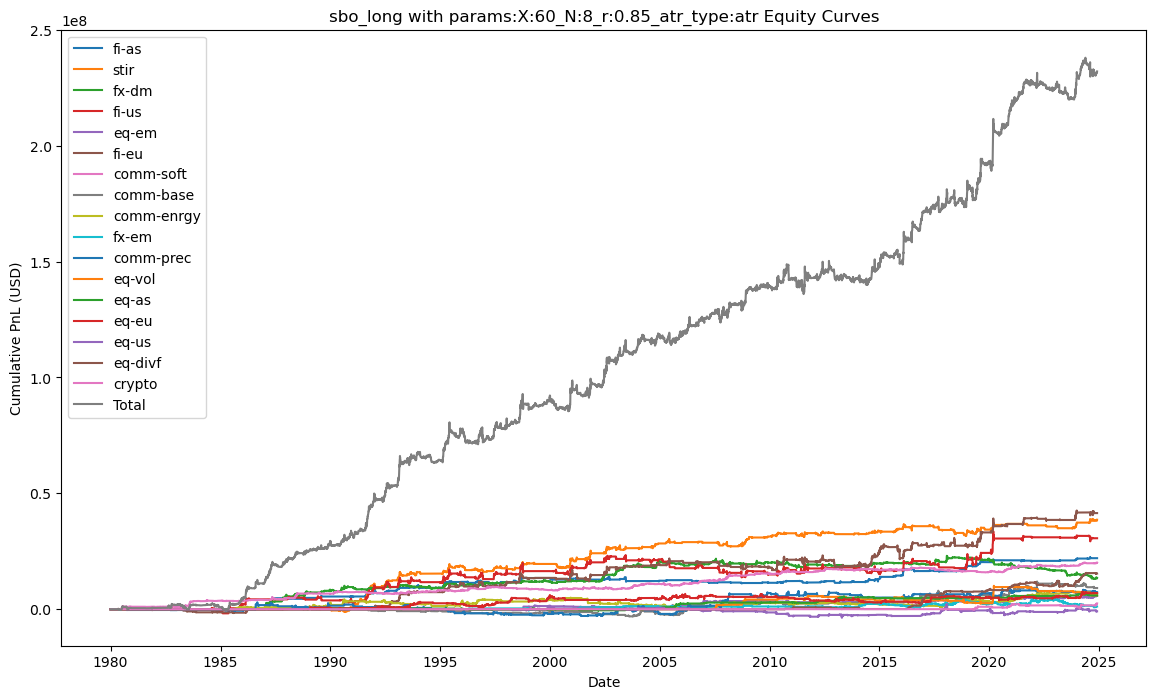

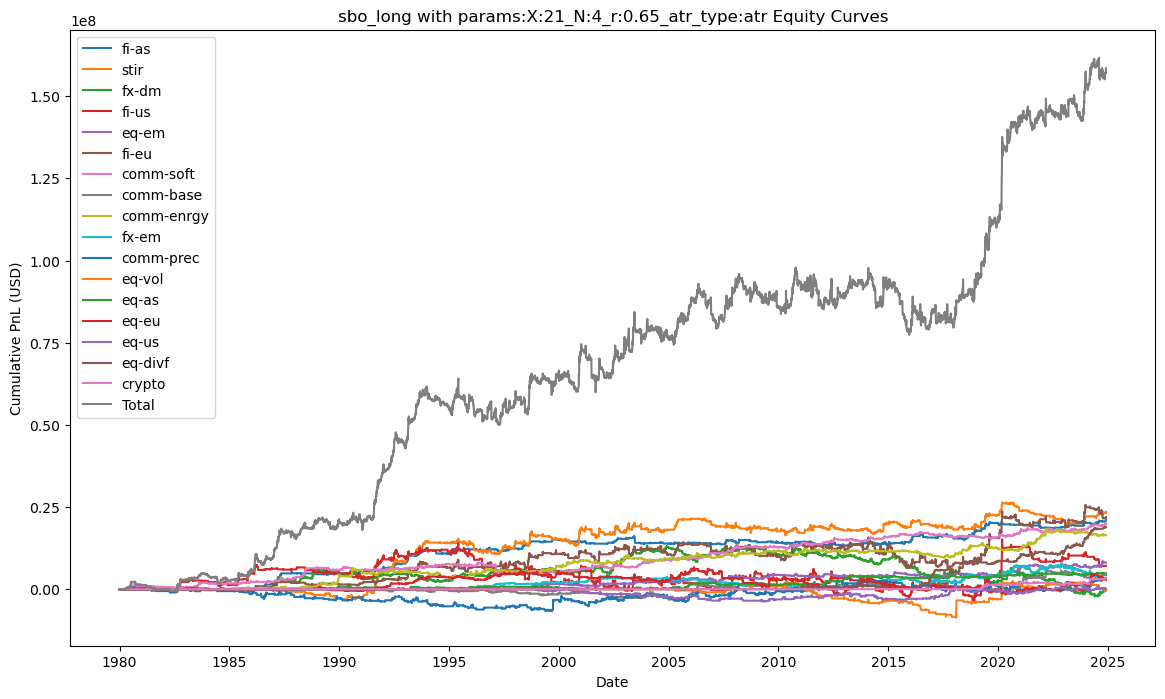

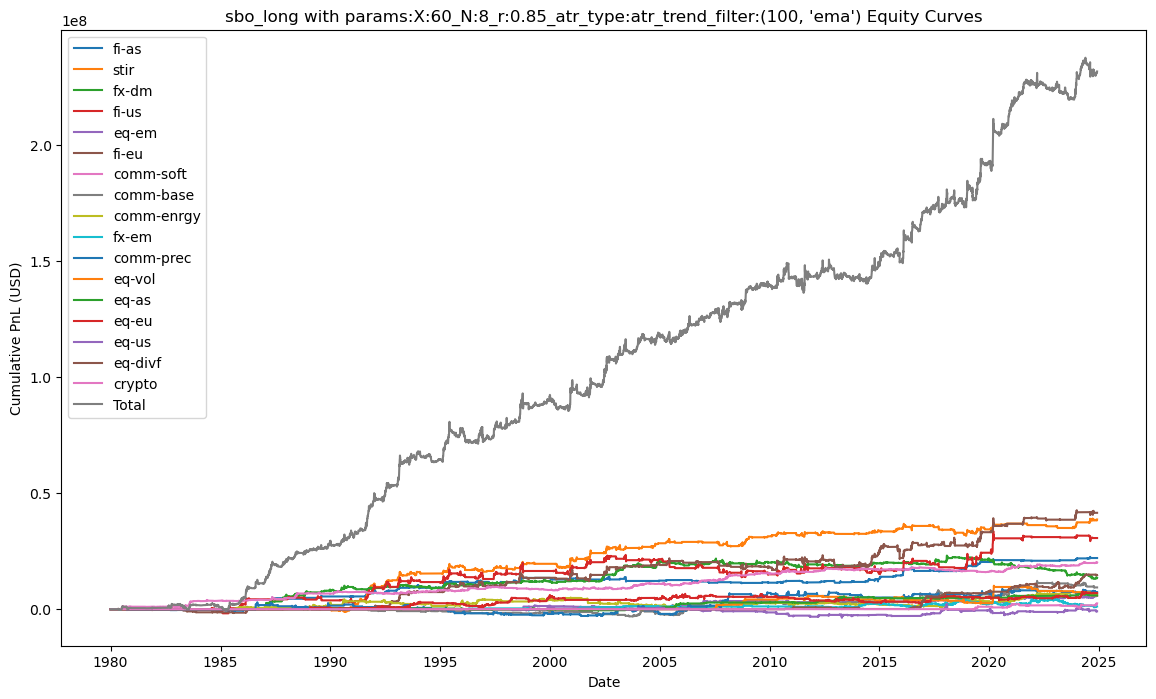

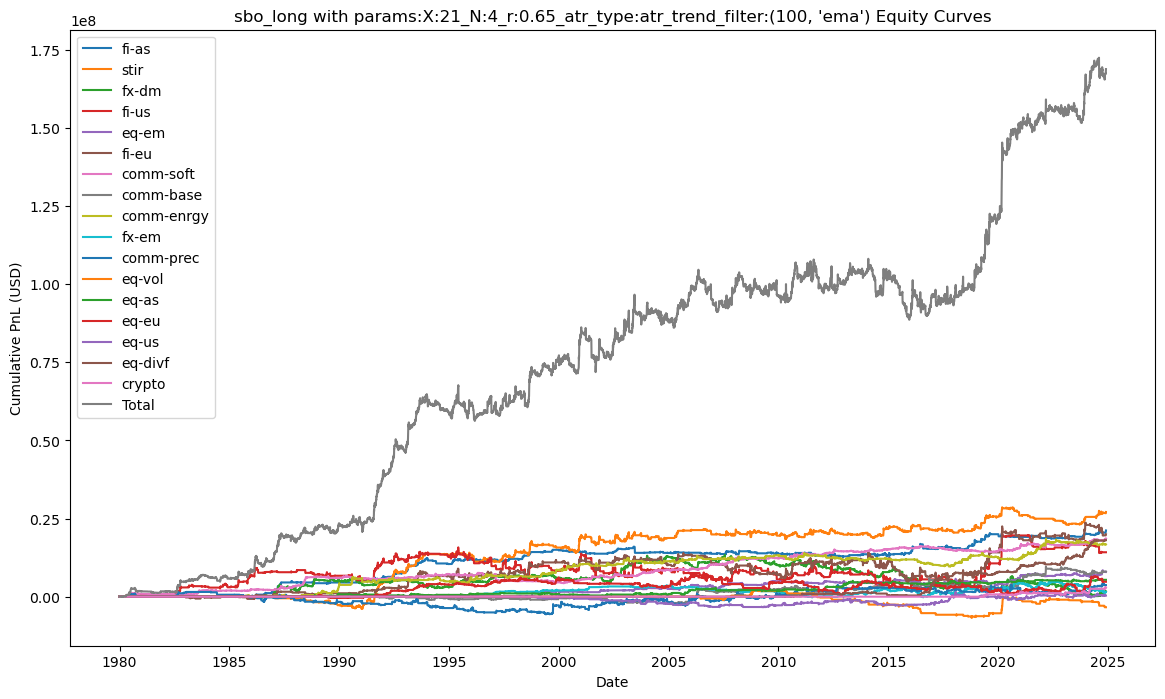

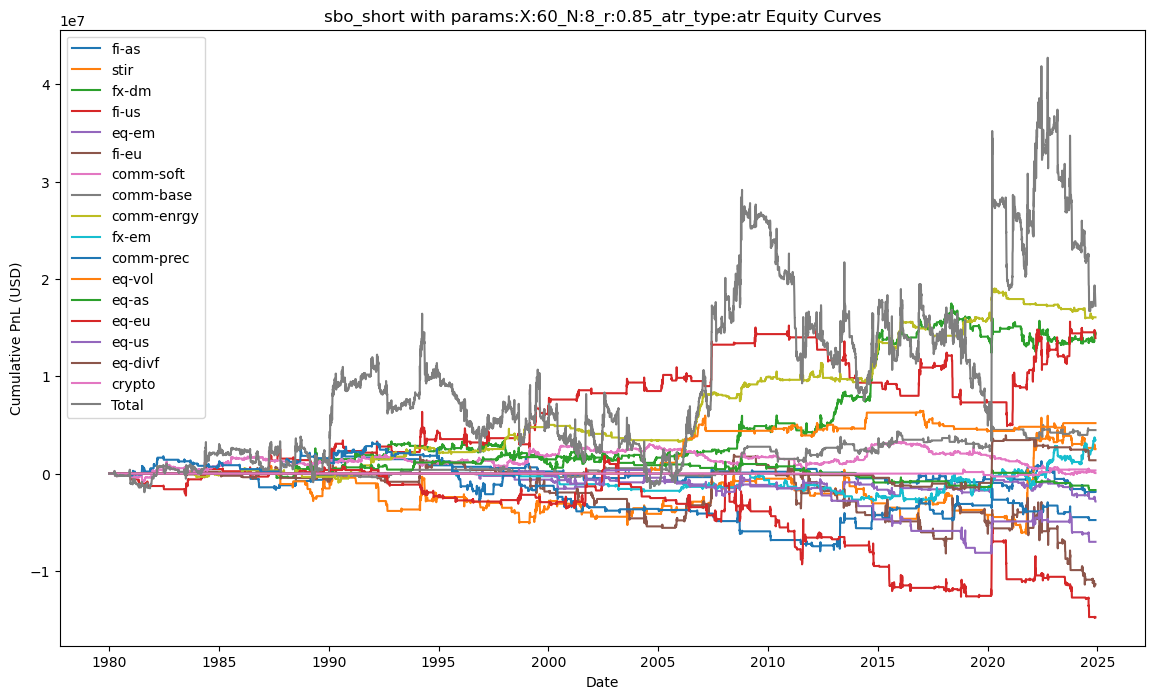

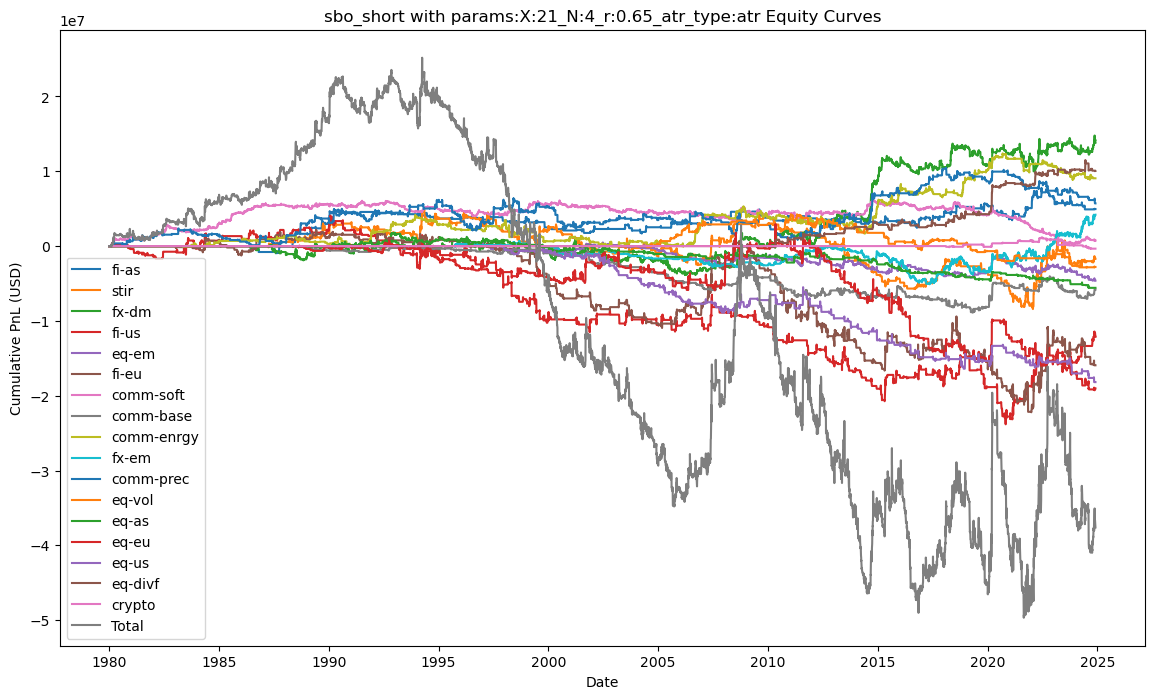

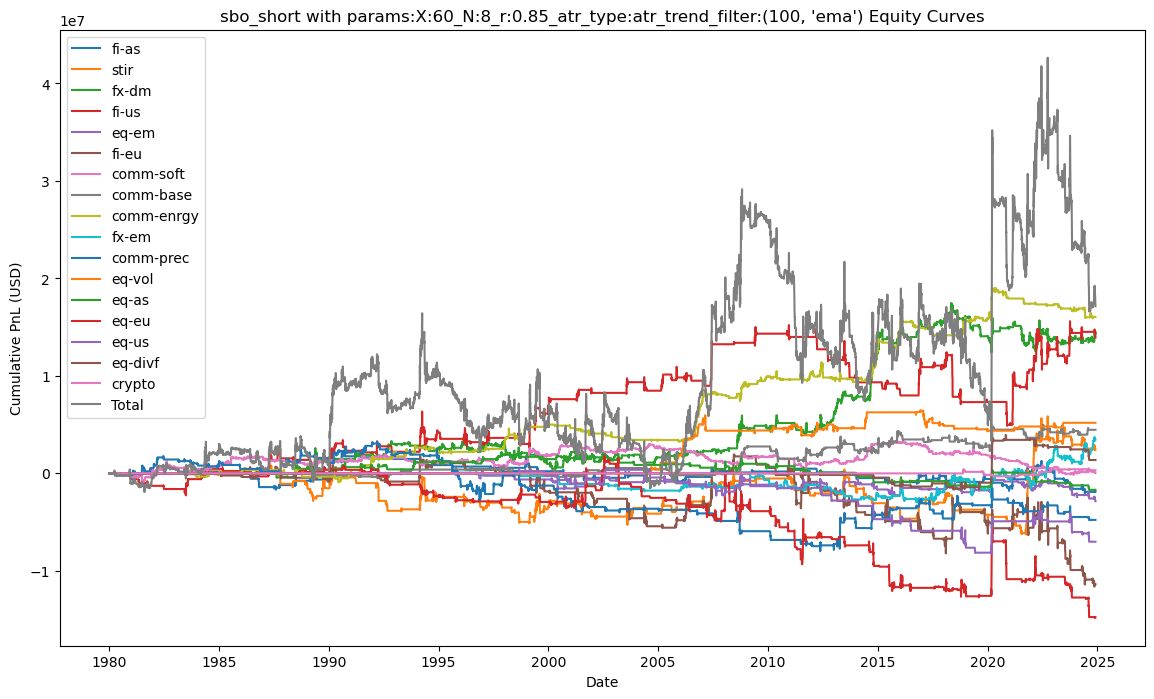

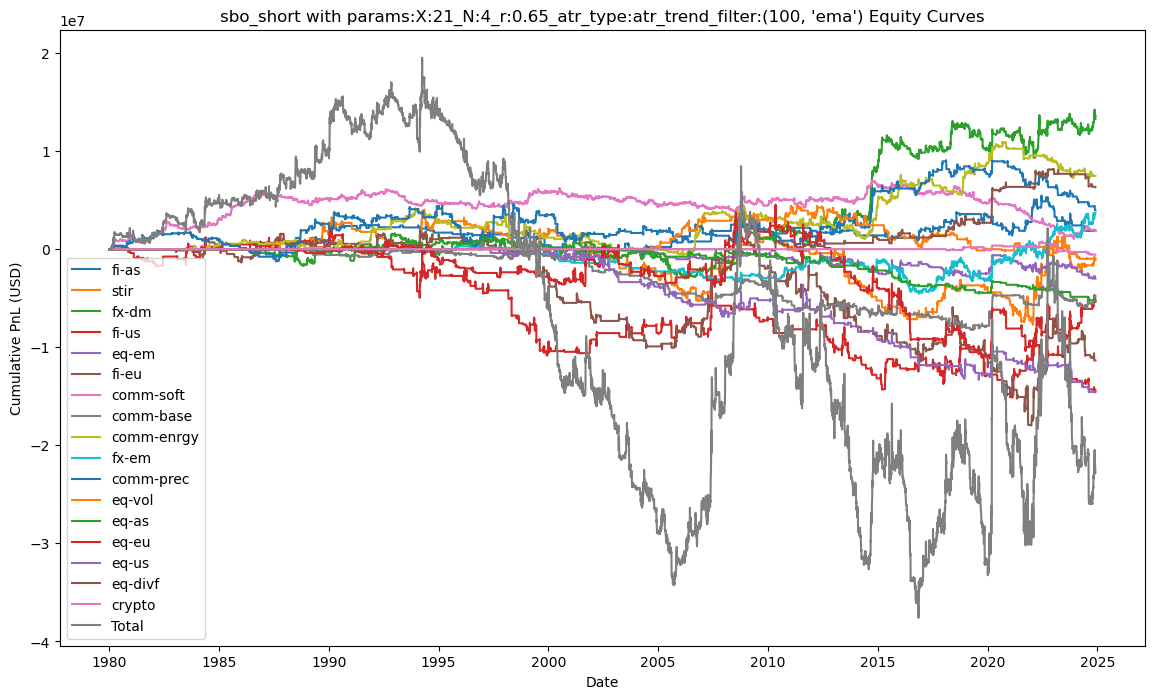

In [122]:
pnl_ts = {}
perf_dfs = {}
pnl_dfs = {}
for tr in trading_rules_dict.values():
    tmppnldf = tr.plot_equity(byac=True,totalsys=True)
    pnl_ts[tr.name_lbl] = tmppnldf
    tmpdf = tr.perf_table(byac=True,metric='sharpe')
    perf_dfs[tr.name_lbl] = tmpdf
    tmpdf = tr.perf_table(byac=True, metric='pnl')
    pnl_dfs[tr.name_lbl] = tmpdf

In [123]:
allsysdf = {}
for tr in trading_rules_dict.values():
    tmp = pnl_ts[tr.name_lbl]
    allsysdf[tr.name_lbl] = tmp['Total']

allsysdf = pd.DataFrame(allsysdf)
allsysdf

rsi_l    rsi_l_tf      rsi_s   rsi_s_tf    rsi_l_ml  \
Date                                                                   
1980-01-02        0.00        0.00       0.00       0.00        0.00   
1980-01-03        0.00        0.00       0.00       0.00        0.00   
1980-01-04        0.00        0.00       0.00       0.00        0.00   
1980-01-07        0.00        0.00       0.00       0.00        0.00   
1980-01-08        0.00        0.00       0.00       0.00        0.00   
...                ...         ...        ...        ...         ...   
2024-11-26 278,124,425 265,501,949 17,421,725 65,071,780 298,973,790   
2024-11-27 278,278,519 265,664,738 17,421,725 65,071,780 299,136,579   
2024-11-28 278,673,809 266,011,354 17,410,685 65,060,740 299,522,150   
2024-11-29 278,921,514 266,274,006 17,529,421 65,179,475 299,555,601   
2024-12-02         NaN         NaN        NaN        NaN 299,555,601   

              rsi_s_ml  simple_slow_l  simple_fast_l  simple_slow_l_tf  \
Date                                                                     
1980-01-02        0.00           0.00           0.00              0.00   
1980-01-03        0.00           0.00           0.00              0.00   
1980-01-04        0.00           0.00           0.00              0.00   
1980-01-07        0.00           0.00           0.00              0.00   
1980-01-08        0.00           0.00           0.00              0.00   
...                ...            ...            ...               ...   
2024-11-26 154,903,265    231,639,797    157,111,728       230,996,005   
2024-11-27 154,903,265    231,700,133    157,495,839       231,056,341   
2024-11-28 154,922,404    231,767,197    158,044,289       231,123,406   
2024-11-29 154,907,092    232,076,422    158,489,088       231,432,631   
2024-12-02         NaN            NaN            NaN               NaN   

            simple_fast_l_tf  simple_slow_s  simple_fast_s  simple_slow_s_tf  \
Date                                                                           
1980-01-02              0.00           0.00           0.00              0.00   
1980-01-03              0.00           0.00           0.00              0.00   
1980-01-04              0.00           0.00           0.00              0.00   
1980-01-07              0.00           0.00           0.00              0.00   
1980-01-08              0.00           0.00           0.00              0.00   
...                      ...            ...            ...               ...   
2024-11-26       167,424,243     17,784,116    -37,087,565        17,695,429   
2024-11-27       167,808,353     17,426,643    -37,534,155        17,337,956   
2024-11-28       168,356,804     17,421,834    -37,548,403        17,333,146   
2024-11-29       168,801,603     17,238,623    -37,604,617        17,149,935   
2024-12-02               NaN            NaN            NaN               NaN   

            simple_fast_s_tf  
Date                          
1980-01-02              0.00  
1980-01-03              0.00  
1980-01-04              0.00  
1980-01-07              0.00  
1980-01-08              0.00  
...                      ...  
2024-11-26       -22,263,192  
2024-11-27       -22,709,782  
2024-11-28       -22,724,030  
2024-11-29       -22,780,245  
2024-12-02               NaN  

[11804 rows x 14 columns]

<Axes: xlabel='Date'>

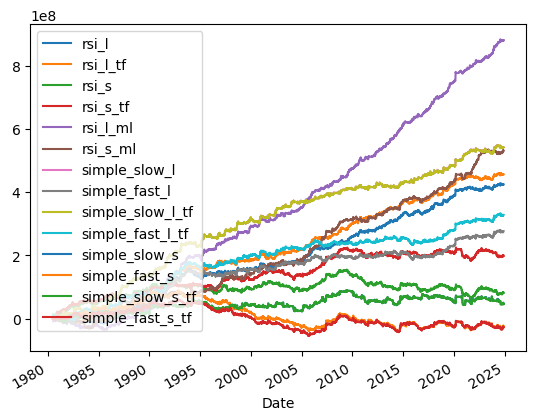

In [124]:
vol_tgt = 10000000
lookback = 126

vol_tgt = 10000000

# Calculate the rolling standard deviation of the last 125 days of returns
rolling_std = allsysdf.diff().rolling(window=lookback).std()

# Calculate the scaling factor to achieve the target annualized volatility
scaling_factor = vol_tgt / (rolling_std * (252 ** 0.5))

# Apply the scaling factor to the returns
scaled_combined_total_df = allsysdf.diff() * scaling_factor
scaled_combined_total_df = scaled_combined_total_df.cumsum()

scaled_combined_total_df.plot()

<Axes: xlabel='Date'>

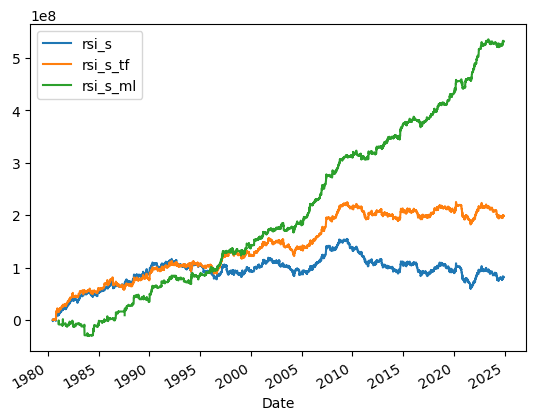

In [125]:
scaled_combined_total_df[['rsi_s', 'rsi_s_tf', 'rsi_s_ml']].plot()

<Axes: xlabel='Date'>

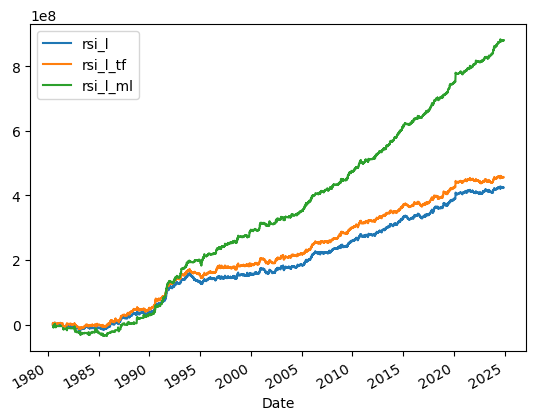

In [126]:
scaled_combined_total_df[['rsi_l', 'rsi_l_tf', 'rsi_l_ml']].plot()

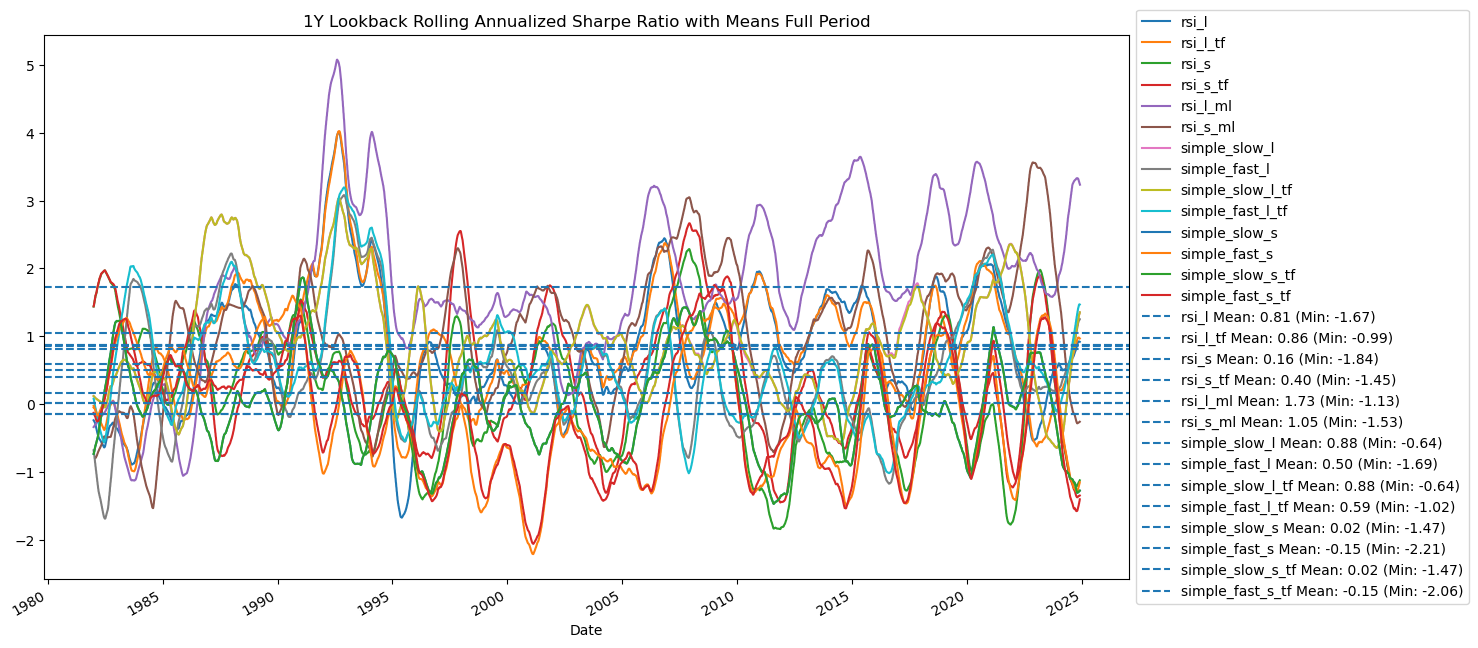

In [127]:

# Calculate the rolling annualized Sharpe ratio for each column in combined_pnl_df
rolling_sharpe = allsysdf.diff().rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
rolling_sharpe = rolling_sharpe.rolling(window=252).mean()
# Calculate the mean of each series in rolling_sharpe
mean_sharpe = rolling_sharpe.mean()
min_sharpe = rolling_sharpe.min()

# Plot the rolling Sharpe ratios
ax = rolling_sharpe.plot(figsize=(14, 8), title='1Y Lookback Rolling Annualized Sharpe Ratio with Means Full Period')

# Plot the mean of each series as dashed lines
for column in rolling_sharpe.columns:
    ax.axhline(y=mean_sharpe[column], linestyle='--', label=f'{column} Mean: {mean_sharpe[column]:.2f} (Min: {min_sharpe[column]:.2f})')
    # Move the legend outside the chart area


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

<Axes: xlabel='Date'>

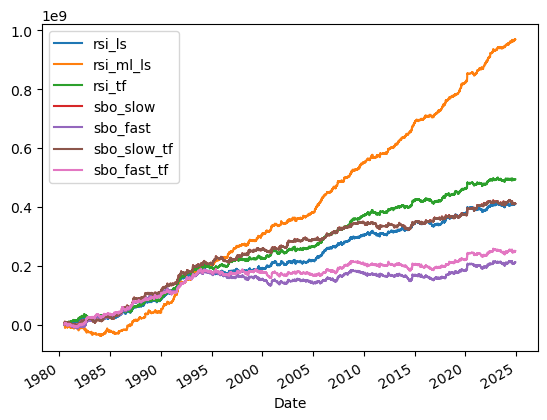

In [128]:
lsdfs = scaled_combined_total_df.copy()
lsdfs['rsi_ls'] = allsysdf['rsi_l'] + allsysdf['rsi_s']
lsdfs['rsi_ml_ls'] = allsysdf['rsi_l_ml'] + allsysdf['rsi_s_ml']
lsdfs['rsi_tf'] = allsysdf['rsi_l_tf'] + allsysdf['rsi_s_tf']
lsdfs['sbo_slow'] = allsysdf['simple_slow_l'] + allsysdf['simple_slow_s']
lsdfs['sbo_fast'] = allsysdf['simple_fast_l'] + allsysdf['simple_fast_s']
lsdfs['sbo_slow_tf'] = allsysdf['simple_slow_l_tf'] + allsysdf['simple_slow_s_tf']
lsdfs['sbo_fast_tf'] = allsysdf['simple_fast_l_tf'] + allsysdf['simple_fast_s_tf']
lsdfs.drop(allsysdf.columns.to_list(), axis=1, inplace=True)
lsdfs

vol_tgt = 10000000
lookback = 126

vol_tgt = 10000000

# Calculate the rolling standard deviation of the last 125 days of returns
rolling_std = lsdfs.diff().rolling(window=lookback).std()

# Calculate the scaling factor to achieve the target annualized volatility
scaling_factor = vol_tgt / (rolling_std * (252 ** 0.5))

# Apply the scaling factor to the returns
scaled_combined_total_df = lsdfs.diff() * scaling_factor
scaled_combined_total_df = scaled_combined_total_df.cumsum()

scaled_combined_total_df.plot()

<Axes: xlabel='Date'>

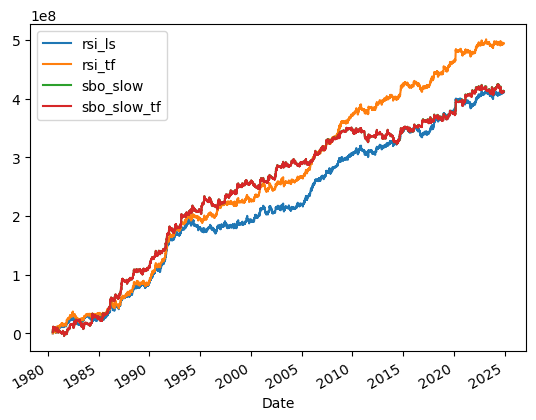

In [129]:
scaled_combined_total_df[['rsi_ls','rsi_tf', 'sbo_slow', 'sbo_slow_tf']].plot()

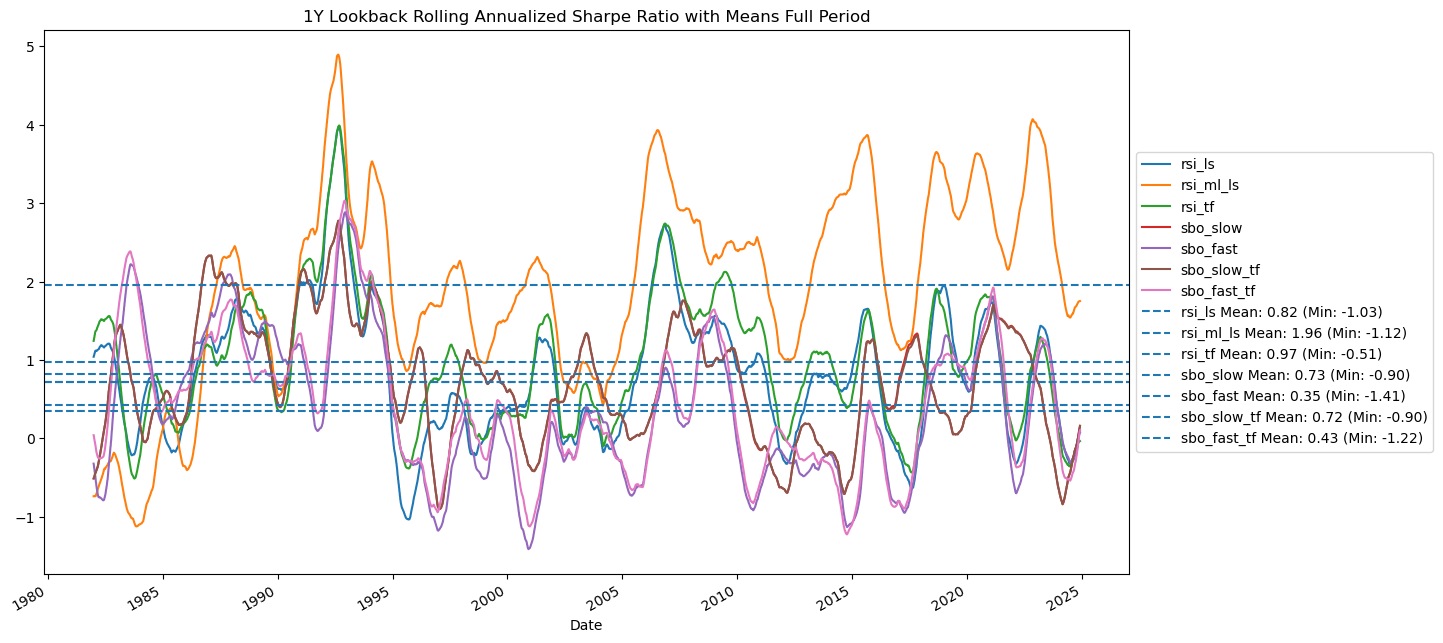

In [130]:

# Calculate the rolling annualized Sharpe ratio for each column in combined_pnl_df
rolling_sharpe = lsdfs.diff().rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
rolling_sharpe = rolling_sharpe.rolling(window=252).mean()
# Calculate the mean of each series in rolling_sharpe
mean_sharpe = rolling_sharpe.mean()
min_sharpe = rolling_sharpe.min()

# Plot the rolling Sharpe ratios
ax = rolling_sharpe.plot(figsize=(14, 8), title='1Y Lookback Rolling Annualized Sharpe Ratio with Means Full Period')

# Plot the mean of each series as dashed lines
for column in rolling_sharpe.columns:
    ax.axhline(y=mean_sharpe[column], linestyle='--', label=f'{column} Mean: {mean_sharpe[column]:.2f} (Min: {min_sharpe[column]:.2f})')
    # Move the legend outside the chart area


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [131]:
ml_short = trading_rules_dict['rsi_s_ml']
ml_long = trading_rules_dict['rsi_l_ml']

In [132]:
display(ml_short.strat_monthly_pnl())
display(ml_long.strat_monthly_pnl())

1          2          3          4          5         6  \
Year                                                                   
1980      0.00       0.00       0.00       0.00       0.00      0.00   
1981    -660.0   -129,700       0.00       0.00       0.00   206,135   
1982   -17,525    142,991    -80,028       0.00     72,225  -311,639   
1983    11,814    -59,812    -32,020    -42,325       0.00      0.00   
1984    51,775       0.00       0.00     21,930       0.00   326,450   
1985   495,341       0.00       0.00     28,260   -118,114    -8,960   
1986   122,240       0.00    -18,500       0.00     25,675   -35,605   
1987      0.00       0.00       0.00       0.00       0.00      0.00   
1988      0.00     49,434       0.00    -17,540    167,848   936,421   
1989  -509,436       0.00       0.00    562,166       0.00  -336,293   
1990 2,639,070    229,101  2,592,025  1,840,172 -1,031,377   851,458   
1991   148,735     -1,388    955,643    -84,139     51,282  -258,801   
1992   -48,587   -228,987    200,832    485,744     46,042    27,366   
1993   323,091   -421,105    102,380       0.00   -624,302    13,221   
1994  -117,313  1,338,701  1,513,003   -686,496   -198,618   -78,049   
1995   140,487    210,147   -439,398     45,214   -124,384   224,755   
1996   486,762   -322,372   -122,933    284,560   -213,871  -117,885   
1997 1,120,921    455,908  1,141,766    351,729    -34,572   284,411   
1998   448,689     26,140   -343,307 -1,119,363     75,414   629,633   
1999  -526,803    689,083   -857,334   -113,969    736,243 1,099,579   
2000   887,422    296,731    -18,838    421,286  2,430,515  -180,861   
2001   -29,547    806,772  1,669,545     80,969   -257,697   -68,904   
2002    62,622   -358,092    480,433   -674,170    396,543 1,089,142   
2003  -166,177    513,317 -2,655,296   -171,244   -216,580    40,875   
2004   194,823   -317,060   -468,263    748,922    354,357   720,061   
2005   365,800  1,113,574    803,047    185,622     68,902      0.00   
2006  -245,495  1,888,277    331,723  1,605,419   -199,497   432,612   
2007 1,149,367 -1,360,513    433,322  1,984,590  4,077,266 3,130,703   
2008 2,116,222   -583,539    -39,802    157,793  1,106,469 1,684,995   
2009   761,911    769,146    419,476    414,652    260,581   354,905   
2010 1,034,683   -436,521    -74,446    267,374   -531,924  -551,295   
2011   902,209   -755,222   -711,359     35,881    109,593   886,993   
2012    40,643    598,477   -875,672    327,065  3,966,615  -332,545   
2013 1,080,680  1,198,063      503.4    224,901    317,521 2,107,962   
2014   -49,154    363,790    312,713   -511,568     98,529  -682,833   
2015 1,684,517   -527,271    150,202   -580,798  1,153,908   563,014   
2016   998,671   -391,723   -956,125   -101,859   -117,928  -505,854   
2017   899,279    -56,981    978,745    516,580    896,446   142,230   
2018 1,440,338 -1,535,605     49,590    608,181  3,143,982 1,457,222   
2019  -435,607   -244,205    104,165    655,469  1,063,699  -271,294   
2020 1,654,195  1,063,065  6,454,423    321,485     96,487    59,044   
2021    33,352  3,630,828  1,114,050    168,253    428,190  -394,856   
2022 3,534,756   -197,028  3,401,038  2,548,186    246,328 9,579,515   
2023  -948,541  3,040,569  2,205,902   -415,645   -226,654  -119,782   
2024   609,365      1,406 -1,284,454     33,026    431,461  -109,922   

              7         8          9         10         11         12  \
Year                                                                    
1980       0.00      0.00       0.00       0.00       0.00       0.00   
1981   -263,715      0.00     -7,810   -135,658      6,545     94,188   
1982   -103,629    68,115     81,658    186,590       0.00     -2,061   
1983       0.00  -732,062       0.00       0.00      7,345    -70,250   
1984    428,957   -28,850       0.00   -132,800     34,338    155,437   
1985    207,325   -69,412       0.00       0.00    -45,133     39,415   
1986    -58,600    94,491    824,989    -70,

1         2          3         4          5          6  \
Year                                                                   
1980       0.00      0.00       0.00      0.00       0.00       0.00   
1981       0.00      0.00       0.00      0.00       0.00       0.00   
1982       0.00      0.00       0.00   -30,388       0.00       0.00   
1983    -74,690      0.00   -568,700    13,254    263,969    -45,050   
1984   -242,975   182,421    146,387    -5,100    224,713       0.00   
1985   -270,562  -445,188   -147,687  -398,223       0.00   -397,325   
1986     76,330   432,808    310,360   217,075    -81,550       0.00   
1987    918,128   284,385  1,488,257   465,598    952,244    -52,267   
1988   -254,651      0.00     -8,631    47,138       0.00    -57,717   
1989   -120,503   264,991       0.00      0.00       0.00    200,969   
1990   -308,748   176,837       0.00   237,833     14,250    222,800   
1991    381,544   820,326       0.00 1,402,697  1,267,147    257,610   
1992   -489,251  -464,950     -1,681  -571,335    333,844  2,168,390   
1993  3,807,282 4,564,917  1,569,374     1,560    188,599  1,617,619   
1994   -426,785  -668,479     -5,017  -188,100    250,235    954,562   
1995   -802,279   301,212  1,845,381 1,137,297  1,951,666   -466,069   
1996   -164,198   192,445     45,468   230,885    -38,285    138,814   
1997 -1,048,950 2,376,788   -432,239    -1,299  1,108,933  1,107,974   
1998   -533,252   241,592    778,176  -400,963    648,809   -718,737   
1999    180,328  -539,165    291,594   519,404    -71,110     60,214   
2000 -1,050,514   156,433    809,168  -220,945    672,903   -433,896   
2001   -290,060  -495,060    343,224   334,785 -1,287,063   -993,344   
2002   -160,532  -345,749    -24,333   862,223    435,724  2,090,247   
2003 -1,475,168   -87,271 -4,930,962   135,390  5,964,379    605,715   
2004  2,054,240  -123,848   -304,829  -321,680    614,857     99,658   
2005   -330,896 1,159,108    756,272 2,323,516    396,976  1,598,390   
2006  2,952,113   782,782    747,964   433,057  2,914,561   -251,678   
2007   -224,581  -249,543    667,983 1,582,115    319,738   -183,688   
2008  2,384,329 3,690,494 -1,013,463   141,932    553,593     33,567   
2009 -1,148,874   635,516   -438,072   547,757    309,178    492,103   
2010    598,359   838,851  2,365,300 1,390,322    463,477    236,520   
2011 -1,635,081 1,117,596  2,087,539 3,701,673 -2,008,051   -156,691   
2012  1,011,756   925,542    159,843 2,250,763  1,554,221     56,507   
2013  2,203,918   334,899   -509,948   929,669  2,834,839   -396,056   
2014  1,191,702 2,325,512     72,741    21,510  1,634,644  1,888,944   
2015  2,340,143 2,231,608   -274,696  -147,483   -487,804    564,927   
2016  2,240,260 1,114,729   -196,138   790,947   -384,035  2,970,111   
2017    913,798   298,504    841,109    44,797    161,049  1,198,762   
2018  4,231,563   502,623  2,029,176   480,101    537,840 -1,887,384   
2019    103,984   882,184    807,528   406,222  1,132,102  4,668,372   
2020  2,211,198 2,552,997 11,416,505  -258,941    423,895  1,572,574   
2021  1,625,952   991,428    -88,119 1,778,679    974,553   -157,260   
2022    768,412   675,205  1,903,115  -375,123   -129,639   -321,882   
2023  1,839,412   230,614    218,628  -659,153      6,670  1,488,625   
2024   -548,593 1,181,657  1,491,371 1,660,738  1,077,504    762,848   

              7          8         9         10         11         12  \
Year                                                                    
1980    -30,282     54,110   -88,842     24,950       0.00       0.00   
1981    -55,398       0.00      0.00       0.00    151,406       0.00   
1982       0.00   -354,812   -13,844   -200,344   -307,469       0.00   
1983    210,605     97,040      0.00       0.00    -69,988    -46,050   
1984       0.00    148,832  -230,750     30,844   -663,148     27,969   
1985    -85,096     74,460   119,610    621,693    769,105    279,745   
1986    -93,055    534,263      0.00       0.

In [133]:
perf = ml_short.perf_table(byassets=True, metric='sharpe', filter_assets=asset_classes['fx-dm'])

In [134]:
perf.head(30)

Period                  2024  2023  2022  2021  2020  2019  2018  2017  2016  \
AssetClass Asset                                                               
Unknown    Total        1.92  0.52  1.51  0.95  1.31  1.32  1.39  0.24 -0.19   
fx-dm      AD1 Curncy   0.74 -0.54  0.28  0.03  1.50  0.12 -0.79 -0.41  0.13   
           BP1 Curncy    NaN  0.74  0.19  0.22  0.04  1.43  0.20  0.21  0.79   
           CD1 Curncy   2.05  0.76 -0.48 -1.01  1.58  0.44  1.04  1.81 -0.19   
           DX1 Curncy    NaN   NaN   NaN   NaN  0.75   NaN   NaN   NaN  0.50   
           EC1 Curncy    NaN   NaN -0.85 -0.01  0.32 -0.68  0.58  0.44 -0.25   
           JY1 Curncy   1.90  1.18  2.53  0.98   NaN  0.68 -0.40  0.98  1.24   
           NO1 Curncy   1.05 -0.31  0.48  1.64  1.29 -0.77  1.00 -1.11 -0.78   
           NV1 Curncy  -0.05  0.64  1.74  0.62   NaN  0.90  1.09 -0.35 -1.17   
           SDE1 Curncy   NaN   NaN -0.54   NaN   NaN   NaN   NaN   NaN   NaN   
           SE1 Curncy   1.56 -0.44 -1.26  1.22 -1.68  1.08  1.21  0.61 -1.12   
           SF1 Curncy  -0.39 -0.24  2.38 -0.27 -1.07  0.97  1.84 -0.62  0.28   

Period                  2015  ...  1998  1997  1996  1995  1994  1993  1992  \
AssetClass Asset              ...                                             
Unknown    Total        1.82  ...  0.78  1.57  1.05  0.97  0.35  0.62  1.65   
fx-dm      AD1 Curncy   0.75  ...   NaN -0.30   NaN   NaN   NaN   NaN   NaN   
           BP1 Curncy  -0.47  ...  1.86  0.95  0.81  0.79 -0.57  1.31  1.14   
           CD1 Curncy   1.42  ...  0.74  1.10 -0.32  0.89  0.91   NaN   NaN   
           DX1 Curncy    NaN  ...   NaN   NaN  0.99  0.09  0.67   NaN   NaN   
           EC1 Curncy   1.31  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           JY1 Curncy   0.10  ... -0.65  0.61 -0.18  0.43 -0.68  0.30  1.39   
           NO1 Curncy   0.07  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           NV1 Curncy   1.29  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           SDE1 Curncy   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           SE1 Curncy   0.65  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           SF1 Curncy   2.17  ...  0.80  1.06  1.66  0.15   NaN  0.26  0.25   

Period                  1991  1990   Avg  
AssetClass Asset                          
Unknown    Total        1.28  1.19  0.95  
fx-dm      AD1 Curncy  -0.04   NaN  0.39  
           BP1 Curncy   1.73   NaN  0.63  
           CD1 Curncy    NaN   NaN  0.62  
           DX1 Curncy    NaN   NaN  0.42  
           EC1 Curncy    NaN   NaN  0.30  
           JY1 Curncy  -0.19  1.19  0.57  
           NO1 Curncy    NaN   NaN  0.38  
           NV1 Curncy    NaN   NaN  0.33  
           SDE1 Curncy   NaN   NaN -0.54  
           SE1 Curncy    NaN   NaN  0.25  
           SF1 Curncy   0.96   NaN  0.35  

[12 rows x 36 columns]

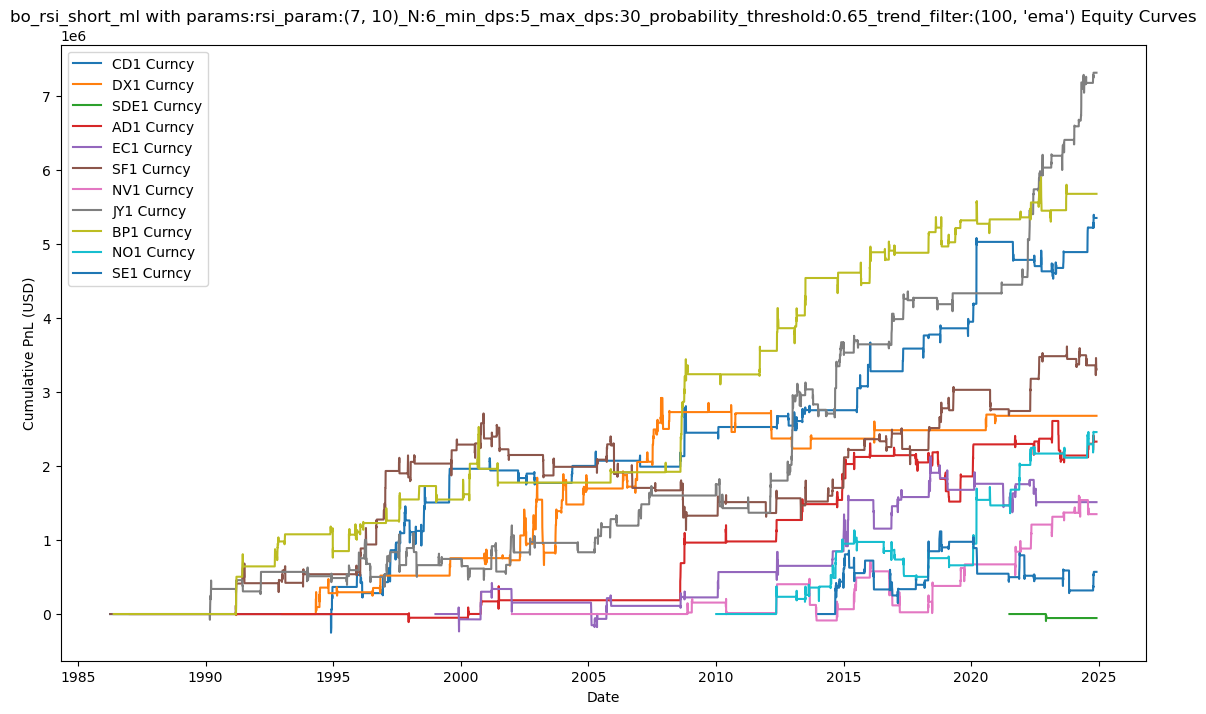

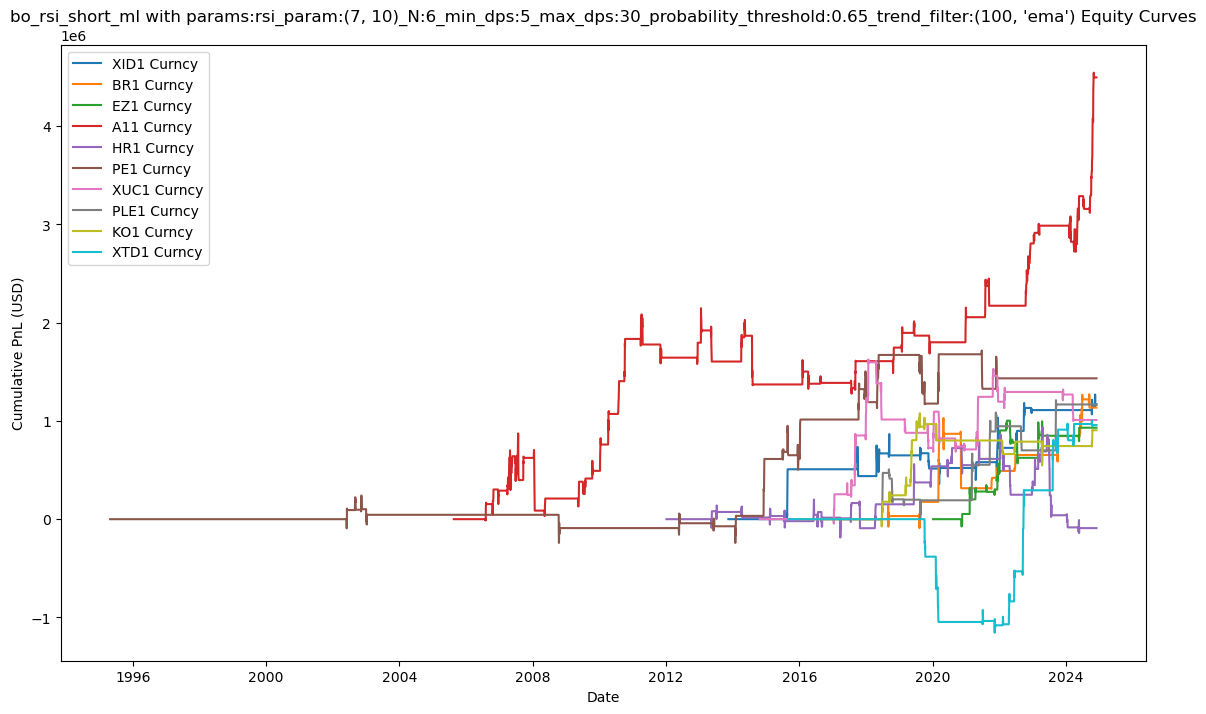

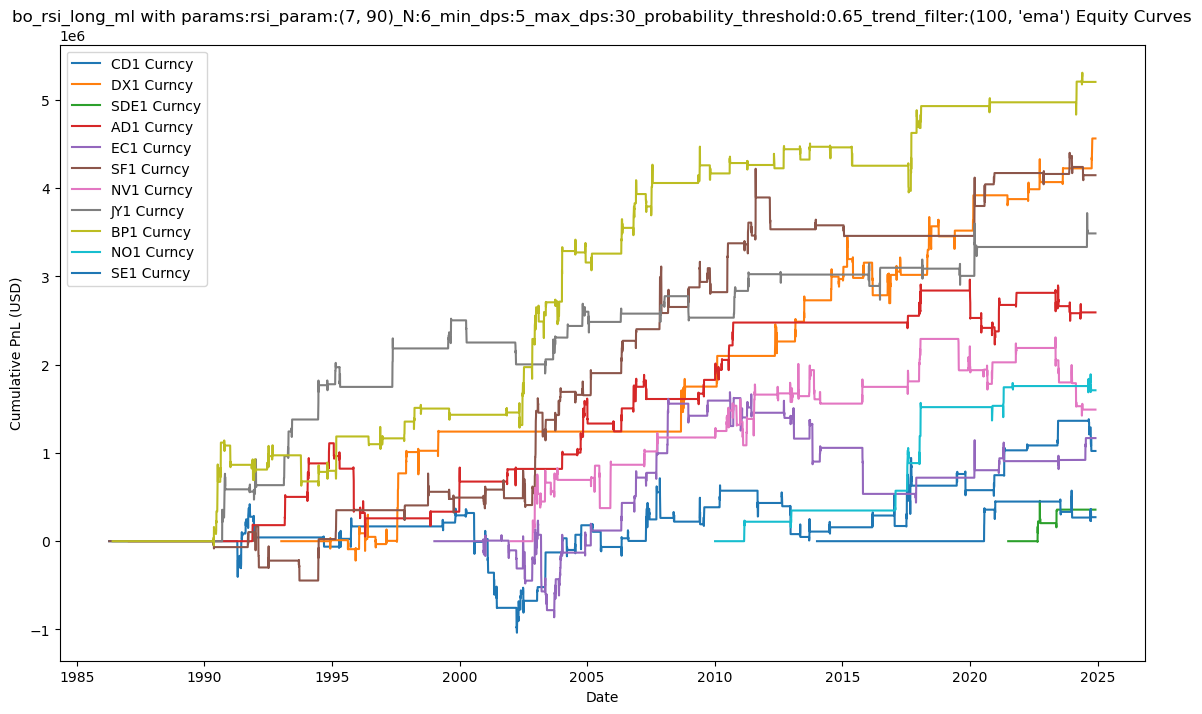

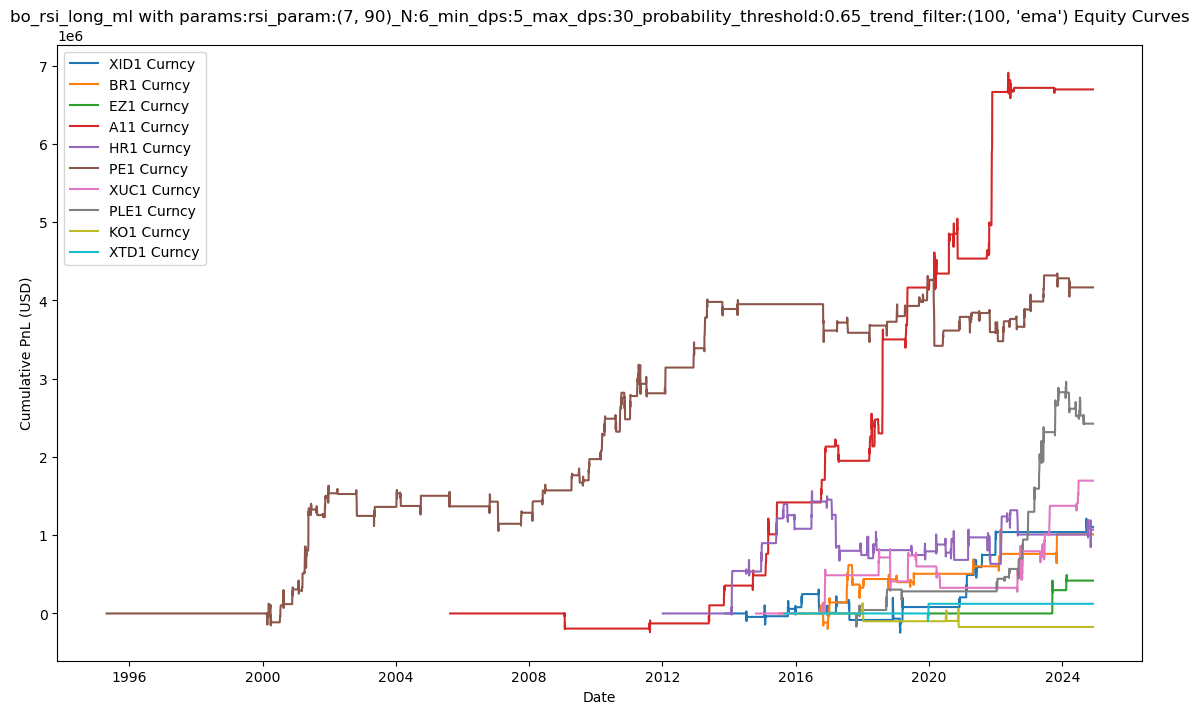

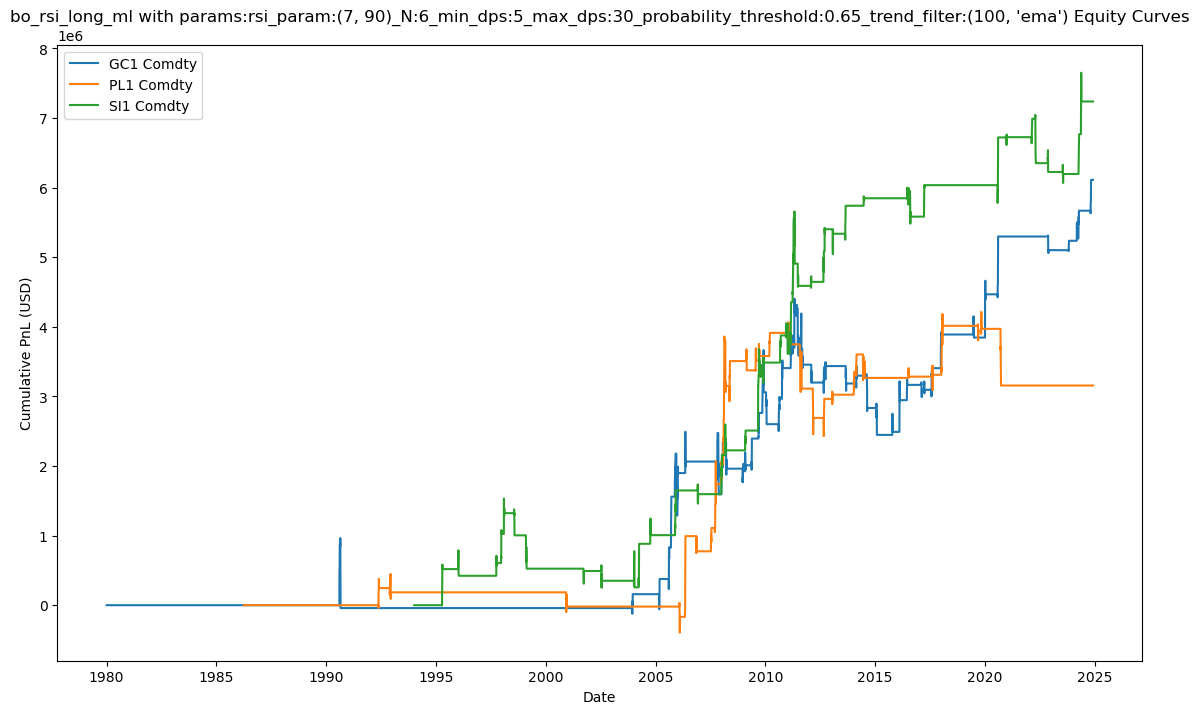

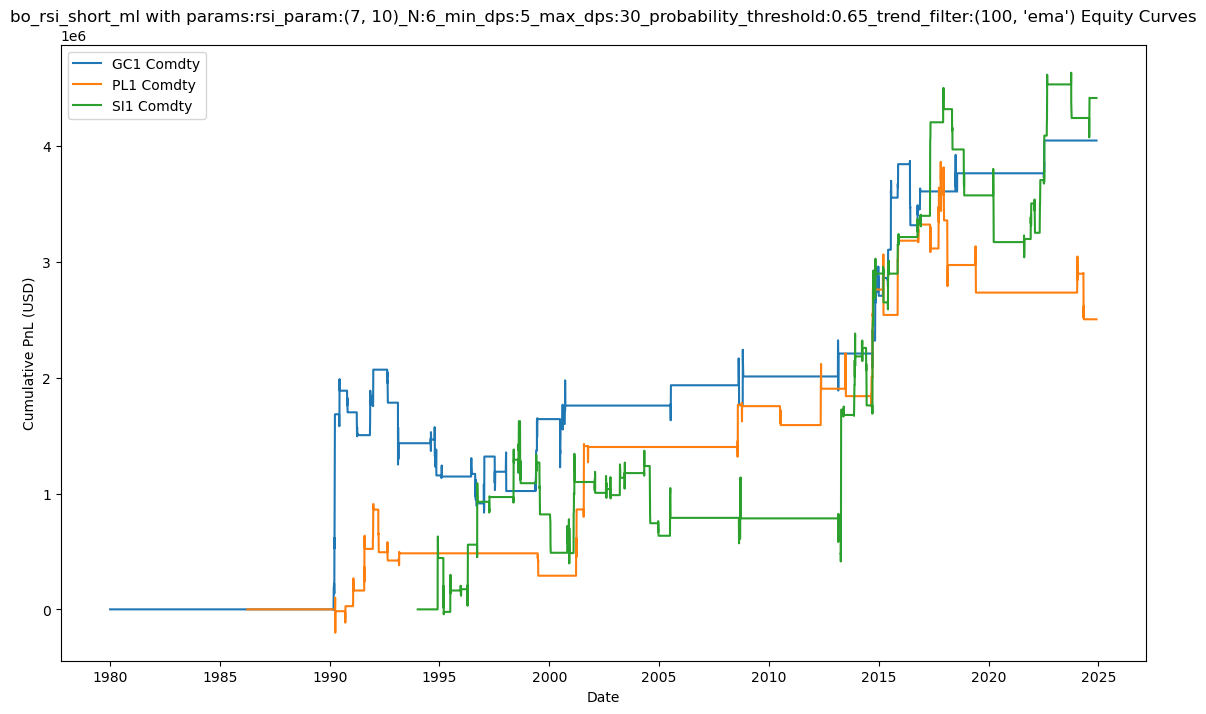

GC1 Comdty  PL1 Comdty  SI1 Comdty      Total
Date                                                     
1980-01-02         NaN         NaN         NaN       0.00
1980-01-03        0.00         NaN         NaN       0.00
1980-01-04        0.00         NaN         NaN       0.00
1980-01-07        0.00         NaN         NaN       0.00
1980-01-08        0.00         NaN         NaN       0.00
...                ...         ...         ...        ...
2024-11-22   4,048,990   2,505,195   4,416,230 10,970,415
2024-11-25   4,048,990   2,505,195   4,416,230 10,970,415
2024-11-26   4,048,990   2,505,195   4,416,230 10,970,415
2024-11-27   4,048,990   2,505,195   4,416,230 10,970,415
2024-11-29   4,048,990   2,505,195   4,416,230 10,970,415

[11310 rows x 4 columns]

In [135]:
ml_short.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fx-dm'])
ml_short.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fx-em'])
ml_long.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fx-dm'])
ml_long.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fx-em'])
ml_long.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['comm-prec'])
ml_short.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['comm-prec'])

In [136]:
tcker = 'BTS1 Comdty'
market_data.get_ticker_data(tcker).to_pandas().to_clipboard()

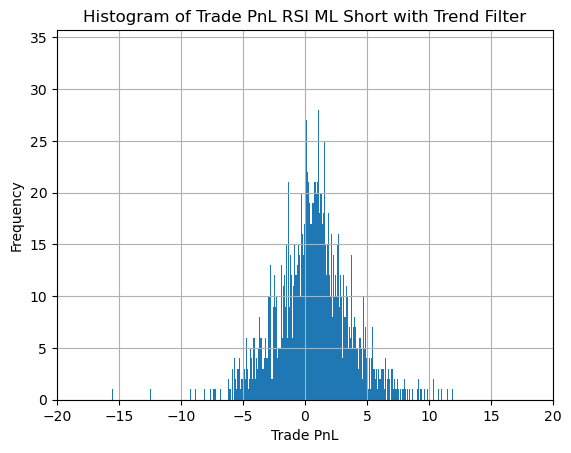

In [137]:
tradeslist_ml_s = ml_short._full_tradeslist()
tradeslist_ml_s
tradeslist_ml_s['Std_PnL'].hist(bins=1000)
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.xlim(-20, 20)
plt.title('Histogram of Trade PnL RSI ML Short with Trend Filter')
plt.show()

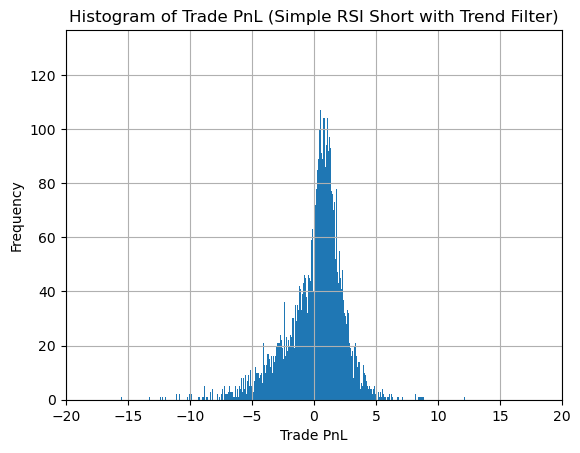

In [138]:
tradeslist_s_tf = trading_rules_dict['rsi_s_tf']._full_tradeslist()
tradeslist_s_tf
tradeslist_s_tf['Std_PnL'].hist(bins=1000)
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.xlim(-20, 20)
plt.title('Histogram of Trade PnL (Simple RSI Short with Trend Filter)')
plt.show()

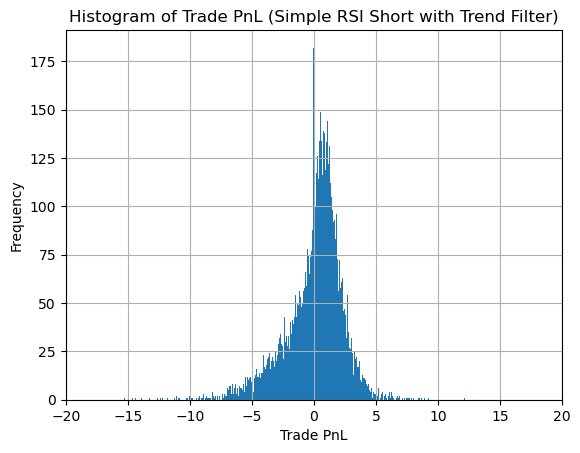

In [139]:
tradeslist_s = trading_rules_dict['rsi_s']._full_tradeslist()
tradeslist_s
tradeslist_s['Std_PnL'].hist(bins=1000)
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.xlim(-20, 20)
plt.title('Histogram of Trade PnL (Simple RSI Short with Trend Filter)')
plt.show()

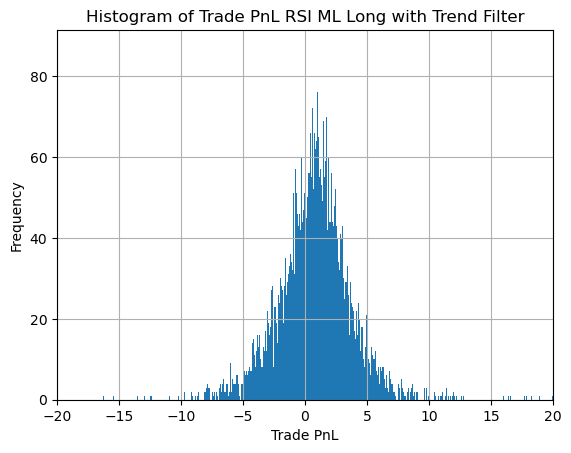

In [140]:
tradeslist_ml_l = ml_long._full_tradeslist()
tradeslist_ml_l
tradeslist_ml_l['Std_PnL'].hist(bins=1000)
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.xlim(-20, 20)
plt.title('Histogram of Trade PnL RSI ML Long with Trend Filter')
plt.show()

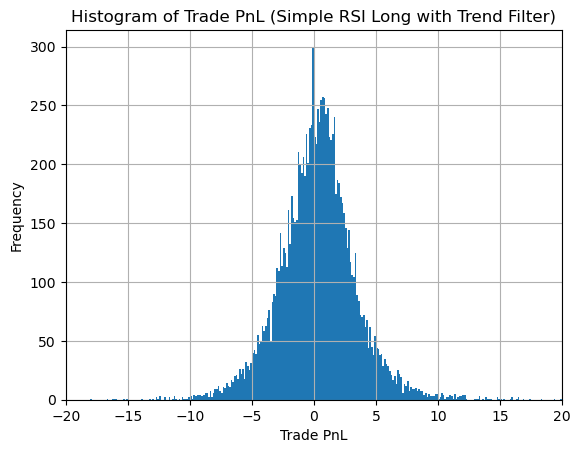

In [141]:
tradeslist_l_tf = trading_rules_dict['rsi_l_tf']._full_tradeslist()
tradeslist_l_tf
tradeslist_l_tf['Std_PnL'].hist(bins=1000)
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.xlim(-20, 20)
plt.title('Histogram of Trade PnL (Simple RSI Long with Trend Filter)')
plt.show()

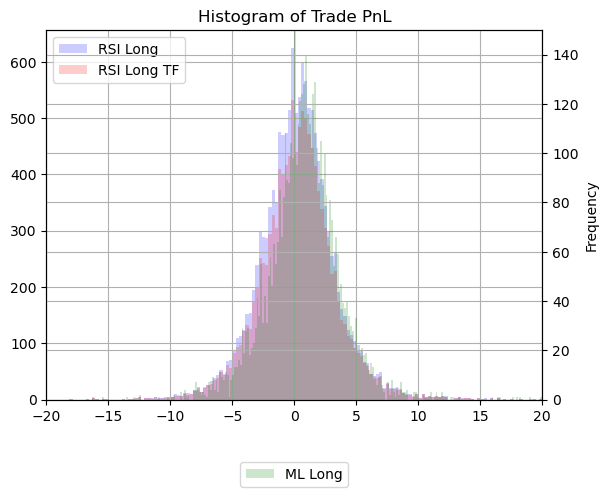

In [142]:
tradeslist_l = trading_rules_dict['rsi_l']._full_tradeslist()
tradeslist_l

tradeslist_l_tf = trading_rules_dict['rsi_l_tf']._full_tradeslist()
tradeslist_l_tf

tradeslist_ml_l = ml_long._full_tradeslist()
tradeslist_ml_l
ax = tradeslist_l['Std_PnL'].hist(bins=500, alpha=0.2, label='RSI Long', color='blue')
ax2 = ax.twinx()

tradeslist_l_tf['Std_PnL'].hist(bins=500, alpha=0.2, label='RSI Long TF', color='red', ax=ax)
tradeslist_ml_l['Std_PnL'].hist(bins=500, alpha=0.2, label='ML Long', ax=ax2, color='green')
ax2.set_ylim(0, 150)


ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.xlim(-20, 20)
plt.title('Histogram of Trade PnL')
plt.show()

In [143]:
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import to_rgba
from scipy.stats import skewnorm, t, norm
from scipy.optimize import minimize
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt

def ged_pdf(x, loc, scale, p):
    # Generalized Error Distribution PDF
    c = p / (2 * scale * gamma(1 / p))
    return c * np.exp(-np.abs((x - loc) / scale) ** p)

def fit_and_plot_dist(data, label, color, dist='skewnorm'):
    num_trades = len(data)
    if dist == 'skewnorm':
        # Fit a skew-normal distribution to the data
        shape, loc, scale = skewnorm.fit(data)
        
        # Generate the fitted line
        x = np.linspace(min(data), max(data), 500)
        pdf_values = skewnorm.pdf(x, shape, loc, scale)
        peak = x[np.argmax(pdf_values)]  # True peak value
        
        # Plot the fitted line
        plt.plot(x, pdf_values, label=f'{label} (num_trades= {num_trades:,.0f}, dist_peak={peak:,.0f}, shape={shape:.2f}, loc={loc:,.2f}, scale={scale:,.2f})', color=color)
    
    elif dist == 'ged':
        # Define negative log-likelihood for GED
        def neg_log_likelihood(params):
            loc, scale, p = params
            if scale <= 0 or p <= 0:  # Constraints
                return np.inf
            return -np.sum(np.log(ged_pdf(data, loc, scale, p)))

        # Initial guesses for parameters
        initial_params = [np.mean(data), np.std(data), 1.5]
        bounds = [(None, None), (1e-5, None), (1e-5, None)]  # Enforce positive scale and p

        # Fit the parameters by minimizing the negative log-likelihood
        result = minimize(neg_log_likelihood, initial_params, bounds=bounds)
        loc, scale, p = result.x
        
        # Generate the fitted line
        x = np.linspace(min(data), max(data), 500)
        pdf_values = ged_pdf(x, loc, scale, p)
        peak = x[np.argmax(pdf_values)]  # True peak value
        
        # Plot the fitted line
        plt.plot(x, pdf_values, label=f'{label} (num_trades= {num_trades:,.0f}, dist_peak={peak:,.0f}, loc={loc:,.2f}, scale={scale:,.2f}, p={p:.2f})', color=color)

    elif dist == 't':
        # Fit a t-distribution to the data
        df, loc, scale = t.fit(data)
        
        # Generate the fitted line
        x = np.linspace(min(data), max(data), 500)
        pdf_values = t.pdf(x, df, loc, scale)
        peak = x[np.argmax(pdf_values)]  # True peak value
        
        # Plot the fitted line
        plt.plot(x, pdf_values, label=f'{label} (num_trades= {num_trades:,.0f}, dist_peak={peak:,.0f}, df={df:.2f}, loc={loc:,.2f}, scale={scale:,.2f})', color=color)

    else:
        # Fit a normal distribution to the data
        mu, std = norm.fit(data)
        
        # Generate the fitted line
        x = np.linspace(min(data), max(data), 500)
        pdf_values = norm.pdf(x, mu, std)
        peak = x[np.argmax(pdf_values)]  # True peak value
        
        # Plot the fitted line
        plt.plot(x, pdf_values, label=f'{label} (num_trades= {num_trades:,.0f}, dist_peak={peak:,.0f}, μ={mu:,.2f}, σ={std:,.2f})', color=color)
    
    # Add a vertical line at the peak
    darker_color = to_rgba(color, alpha=1.0)  # Get the RGBA value of the color
    darker_color = tuple(c * 0.6 for c in darker_color[:3]) + (1.0,)  # Make it darker
    plt.axvline(x=peak, color=darker_color, linestyle='--', linewidth=1)


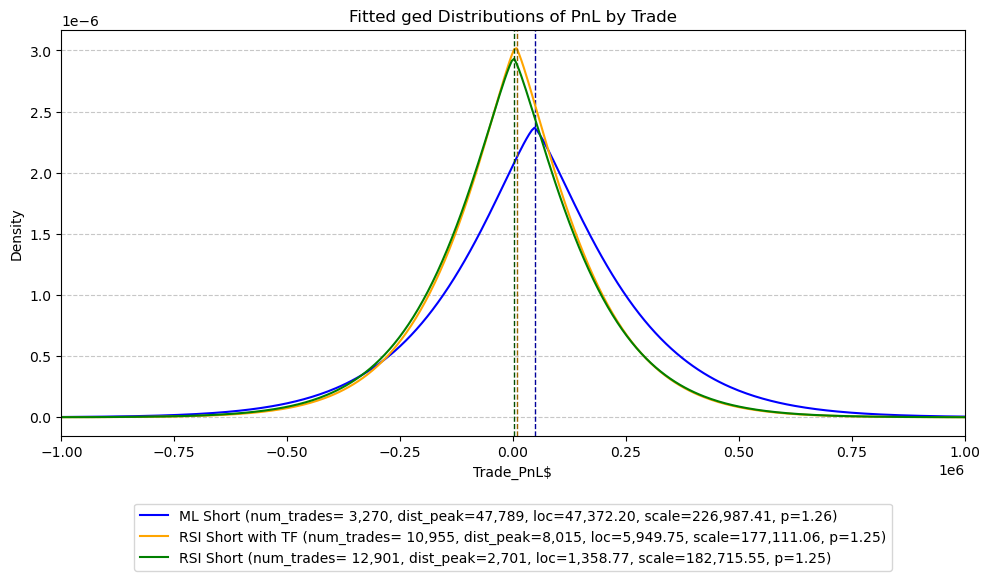

In [144]:
type_trade = 'Trade_PnL'
model_dist = 'ged'
ml_short_tl = tradeslist_ml_s[type_trade]
rsi_short_tf_tl = tradeslist_s_tf[type_trade]
rsi_short_tl = tradeslist_s[type_trade]


# Plot the fitted lines
plt.figure(figsize=(10, 6))
fit_and_plot_dist(ml_short_tl, 'ML Short', 'blue', dist=model_dist)
fit_and_plot_dist(rsi_short_tf_tl, 'RSI Short with TF', 'orange', dist=model_dist)
fit_and_plot_dist(rsi_short_tl, 'RSI Short', 'green', dist=model_dist)

plt.title(f'Fitted {model_dist} Distributions of PnL by Trade')
plt.xlabel(type_trade+'$')
plt.ylabel('Density')
plt.xlim(-1000000,1000000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Add titles and labels


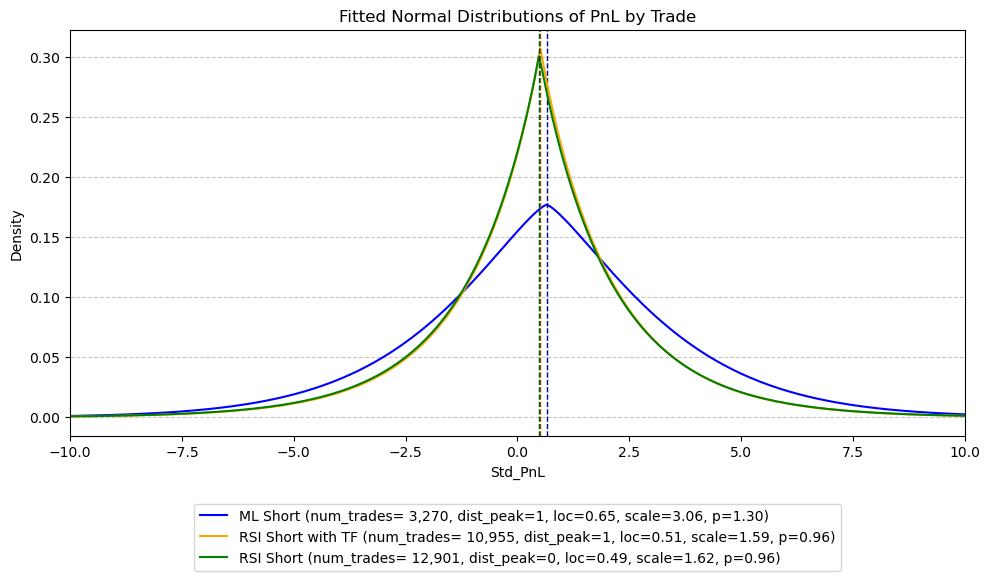

In [145]:
type_trade = 'Std_PnL'
model_dist = 'ged'
ml_short_tl = tradeslist_ml_s[type_trade]
rsi_short_tf_tl = tradeslist_s_tf[type_trade]
rsi_short_tl = tradeslist_s[type_trade]


# Plot the fitted lines
plt.figure(figsize=(10, 6))
fit_and_plot_dist(ml_short_tl, 'ML Short', 'blue', dist=model_dist)
fit_and_plot_dist(rsi_short_tf_tl, 'RSI Short with TF', 'orange', dist=model_dist)
fit_and_plot_dist(rsi_short_tl, 'RSI Short', 'green', dist=model_dist)

plt.title('Fitted Normal Distributions of PnL by Trade')
plt.xlabel(type_trade)
plt.ylabel('Density')
plt.xlim(-10,10)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Add titles and labels


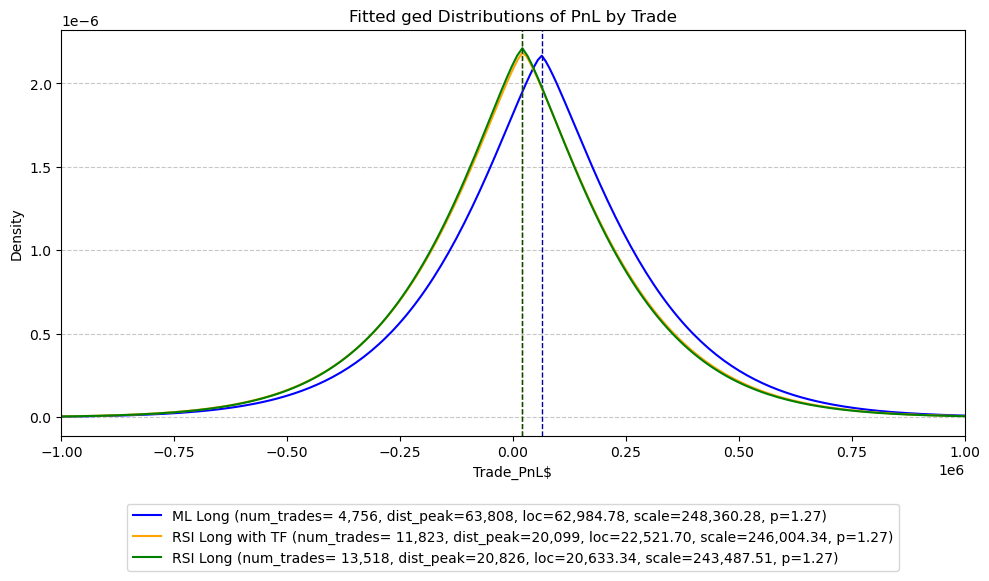

In [146]:
type_trade = 'Trade_PnL'
model_dist = 'ged'
ml_long_tl = tradeslist_ml_l[type_trade]
rsi_long_tf_tl = tradeslist_l_tf[type_trade]
rsi_long_tl = tradeslist_l[type_trade]


# Plot the fitted lines
plt.figure(figsize=(10, 6))
fit_and_plot_dist(ml_long_tl, 'ML Long', 'blue', dist=model_dist)
fit_and_plot_dist(rsi_long_tf_tl, 'RSI Long with TF', 'orange', dist=model_dist)
fit_and_plot_dist(rsi_long_tl, 'RSI Long', 'green', dist=model_dist)

plt.title(f'Fitted {model_dist} Distributions of PnL by Trade')
plt.xlabel(type_trade+'$')
plt.ylabel('Density')
plt.xlim(-1000000,1000000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Add titles and labels


In [147]:
tradeslist.sort_values('Std_PnL', ascending=False).tail(20).to_clipboard()

In [148]:
fxtrades = tradeslist[tradeslist['AssetClass']=='fx-dm']
fxtrades

Descr AssetClass        Asset  FirstDate  \
Trade_ID                                                                
b93a_SF1Cur_1    CHF CURRENCY FUT       fx-dm   SF1 Curncy 1986-04-22   
b93a_CD1Cur_1    C$ CURRENCY FUT        fx-dm   CD1 Curncy 1986-05-21   
b93a_JY1Cur_1    JPN YEN CURR FUT       fx-dm   JY1 Curncy 1986-06-12   
b93a_SF1Cur_2    CHF CURRENCY FUT       fx-dm   SF1 Curncy 1986-07-02   
b93a_BP1Cur_1    BP CURRENCY FUT        fx-dm   BP1 Curncy 1986-07-02   
...                            ...        ...          ...        ...   
b93a_CD1Cur_190  C$ CURRENCY FUT        fx-dm   CD1 Curncy 2024-09-25   
b93a_DX1Cur_156  DOLLAR INDEX           fx-dm   DX1 Curncy 2024-10-08   
b93a_SDE1Cu_11   Mini USD/SGD Fut       fx-dm  SDE1 Curncy 2024-10-10   
b93a_DX1Cur_157  DOLLAR INDEX           fx-dm   DX1 Curncy 2024-10-18   
b93a_SDE1Cu_12   Mini USD/SGD Fut       fx-dm  SDE1 Curncy 2024-10-30   

                  LastDate  TradeEntry  TradeExit  USD_Notional  Num_Lots  \
Trade_ID                                                                    
b93a_SF1Cur_1   1986-05-02       113.2      113.0    13,020,300      92.0   
b93a_CD1Cur_1   1986-06-02        59.0       57.0    18,800,265     319.0   
b93a_JY1Cur_1   1986-06-20       142.0      141.0    18,616,500     105.0   
b93a_SF1Cur_2   1986-07-11       114.4      113.8    18,175,288     127.0   
b93a_BP1Cur_1   1986-07-11        80.5       76.0     5,944,250     118.0   
...                    ...         ...        ...           ...       ...   
b93a_CD1Cur_190 2024-10-03        74.6       73.9    30,561,400     410.0   
b93a_DX1Cur_156 2024-10-16       102.2      103.4    22,608,521     221.0   
b93a_SDE1Cu_11  2024-10-18        1.30       1.31    23,907,946     2,403   
b93a_DX1Cur_157 2024-10-28       103.6      104.2    26,638,564     257.0   
b93a_SDE1Cu_12  2024-11-07        1.32       1.32    31,846,415     3,192   

                 Trade_PnL  Price_PnL  20d_Price_Vol  Std_PnL  
Trade_ID                                                       
b93a_SF1Cur_1      -36,225      -0.18           0.66    -0.27  
b93a_CD1Cur_1     -616,300      -1.93           0.22    -8.77  
b93a_JY1Cur_1     -162,288      -1.06           0.51    -2.10  
b93a_SF1Cur_2     -121,200      -0.67           0.42    -1.58  
b93a_BP1Cur_1     -353,656      -4.55           1.00    -4.56  
...                    ...        ...            ...      ...  
b93a_CD1Cur_190   -266,235      -0.66           0.18    -3.69  
b93a_DX1Cur_156    274,869       1.16           0.31     3.71  
b93a_SDE1Cu_11     112,993       0.01           0.00     1.36  
b93a_DX1Cur_157    142,778       0.59           0.28     2.12  
b93a_SDE1Cu_12      22,077       0.00           0.00     0.39  

[1346 rows x 13 columns]

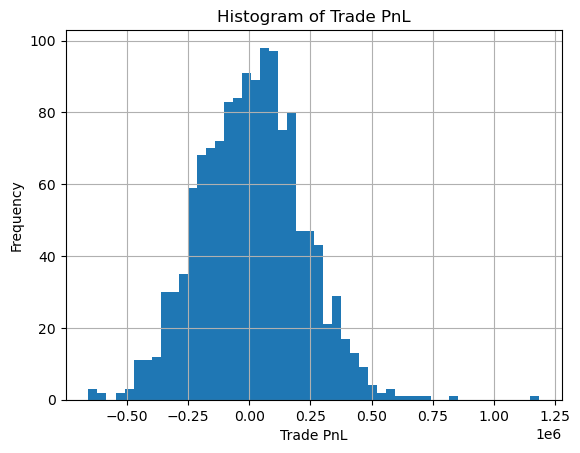

In [149]:
fxtrades['Trade_PnL'].hist(bins=50)
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.title('Histogram of Trade PnL')
plt.show()

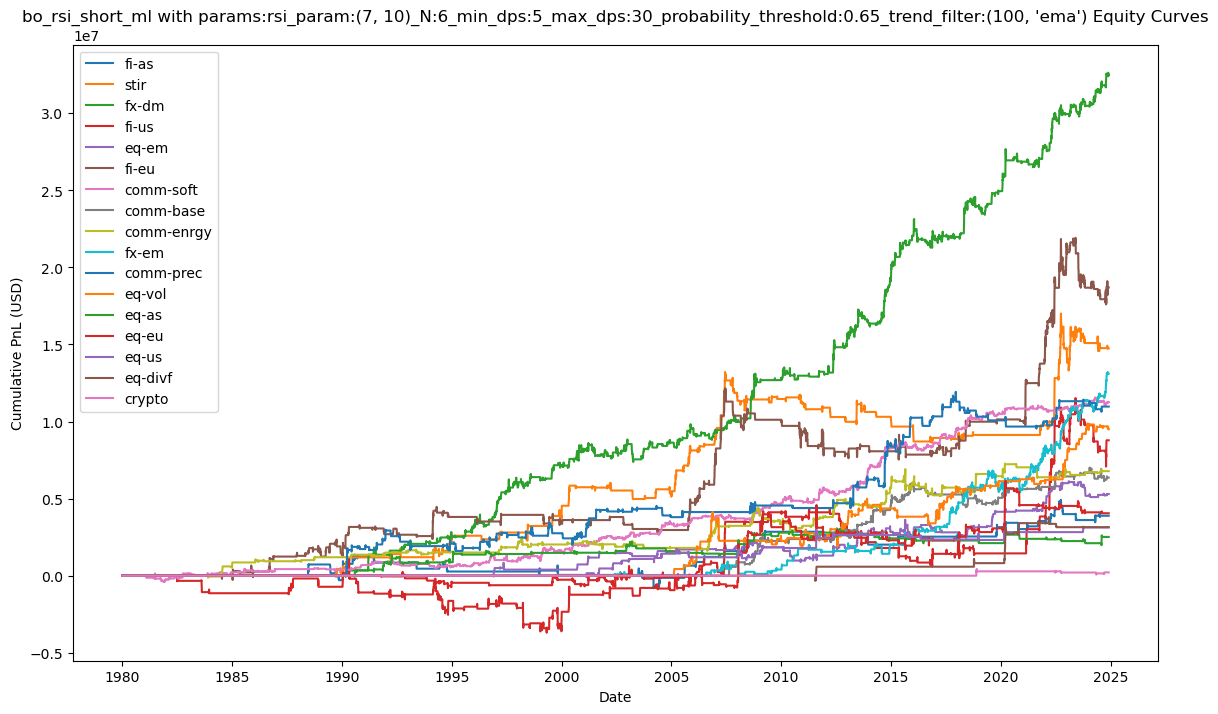

In [150]:
pnls = ml_short.plot_equity(byac=True, totalsys=False)

In [151]:
pnls

fi-as       stir      fx-dm     fi-us     eq-em      fi-eu  \
Date                                                                        
1980-01-02      0.00       0.00       0.00      0.00      0.00       0.00   
1980-01-03      0.00       0.00       0.00      0.00      0.00       0.00   
1980-01-04      0.00       0.00       0.00      0.00      0.00       0.00   
1980-01-07      0.00       0.00       0.00      0.00      0.00       0.00   
1980-01-08      0.00       0.00       0.00      0.00      0.00       0.00   
...              ...        ...        ...       ...       ...        ...   
2024-11-25 3,888,708 14,735,474 32,466,911 8,781,391 5,296,605 18,697,784   
2024-11-26 3,888,708 14,735,474 32,466,911 8,781,391 5,296,605 18,697,784   
2024-11-27 3,888,708 14,735,474 32,466,911 8,781,391 5,296,605 18,697,784   
2024-11-28 3,888,708 14,735,474 32,466,911 8,781,391 5,296,605 18,697,784   
2024-11-29 3,888,708 14,735,474 32,466,911 8,781,391 5,296,605 18,697,784   

            comm-soft  comm-base  comm-enrgy      fx-em  comm-prec    eq-vol  \
Date                                                                           
1980-01-02       0.00       0.00        0.00       0.00       0.00      0.00   
1980-01-03       0.00       0.00        0.00       0.00       0.00      0.00   
1980-01-04       0.00       0.00        0.00       0.00       0.00      0.00   
1980-01-07       0.00       0.00        0.00       0.00       0.00      0.00   
1980-01-08       0.00       0.00        0.00       0.00       0.00      0.00   
...               ...        ...         ...        ...        ...       ...   
2024-11-25 11,256,863  6,363,934   6,783,198 13,106,187 10,970,415 9,496,045   
2024-11-26 11,256,863  6,363,934   6,783,198 13,106,187 10,970,415 9,496,045   
2024-11-27 11,256,863  6,363,934   6,783,198 13,106,187 10,970,415 9,496,045   
2024-11-28 11,276,002  6,363,934   6,783,198 13,106,187 10,970,415 9,496,045   
2024-11-29 11,260,690  6,363,934   6,783,198 13,106,187 10,970,415 9,496,045   

               eq-as     eq-eu     eq-us   eq-divf  crypto       Total  
Date                                                                    
1980-01-02      0.00      0.00      0.00      0.00    0.00        0.00  
1980-01-03      0.00      0.00      0.00      0.00    0.00        0.00  
1980-01-04      0.00      0.00      0.00      0.00    0.00        0.00  
1980-01-07      0.00      0.00      0.00      0.00    0.00        0.00  
1980-01-08      0.00      0.00      0.00      0.00    0.00        0.00  
...              ...       ...       ...       ...     ...         ...  
2024-11-25 2,514,500 4,051,040 3,133,420 3,147,089 213,700 154,903,265  
2024-11-26 2,514,500 4,051,040 3,133,420 3,147,089 213,700 154,903,265  
2024-11-27 2,514,500 4,051,040 3,133,420 3,147,089 213,700 154,903,265  
2024-11-28 2,514,500 4,051,040 3,133,420 3,147,089 213,700 154,922,404  
2024-11-29 2,514,500 4,051,040 3,133,420 3,147,089 213,700 154,907,092  

[11803 rows x 18 columns]

In [152]:
allpnls = pnls.iloc[-1].sort_values(ascending=False)

In [153]:
allpnls.to_clipboard()

<Axes: >

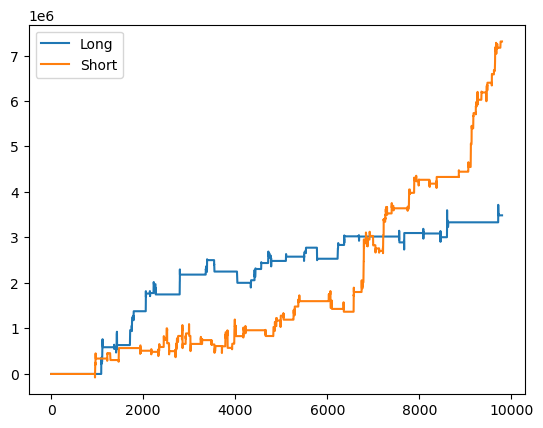

In [154]:
gcbt_s = ml_short._get_btdf('JY1 Curncy')
gcbt_l = ml_long._get_btdf('JY1 Curncy')
gcshort = gcbt_s['Strategy_Equity_USD']
gclong = gcbt_l['Strategy_Equity_USD']

gclongshort = pd.DataFrame({'Long':gclong,'Short':gcshort})
gclongshort.plot()

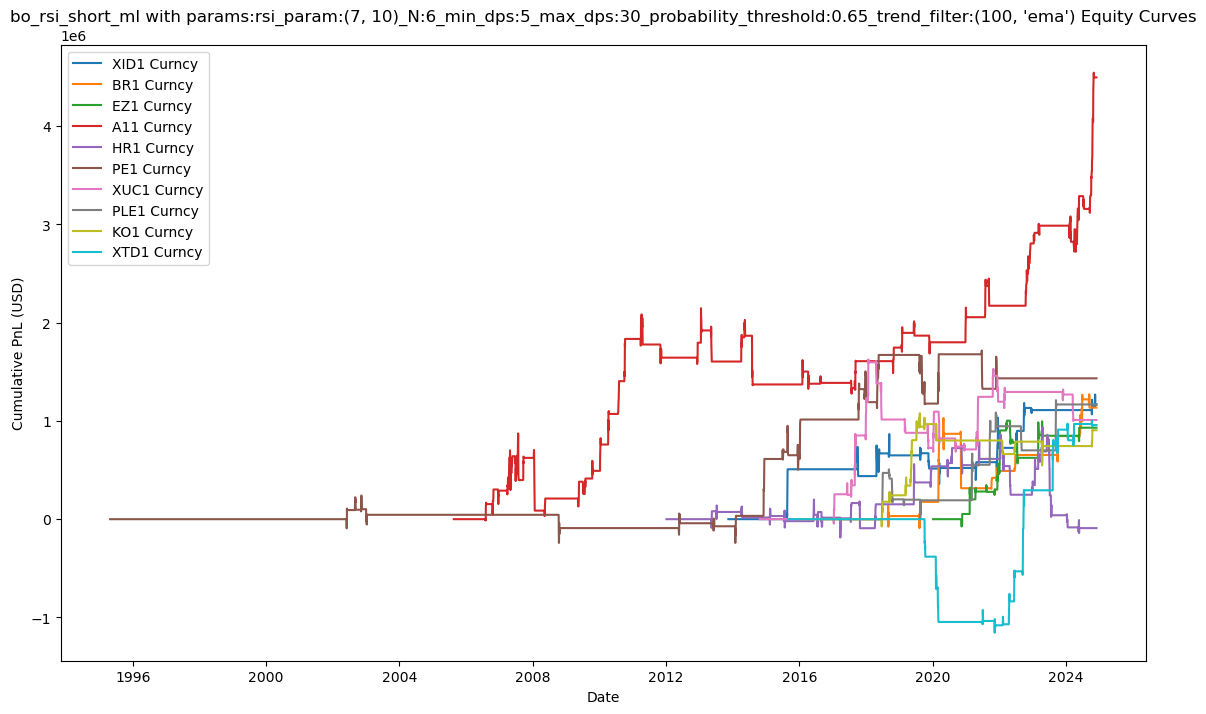

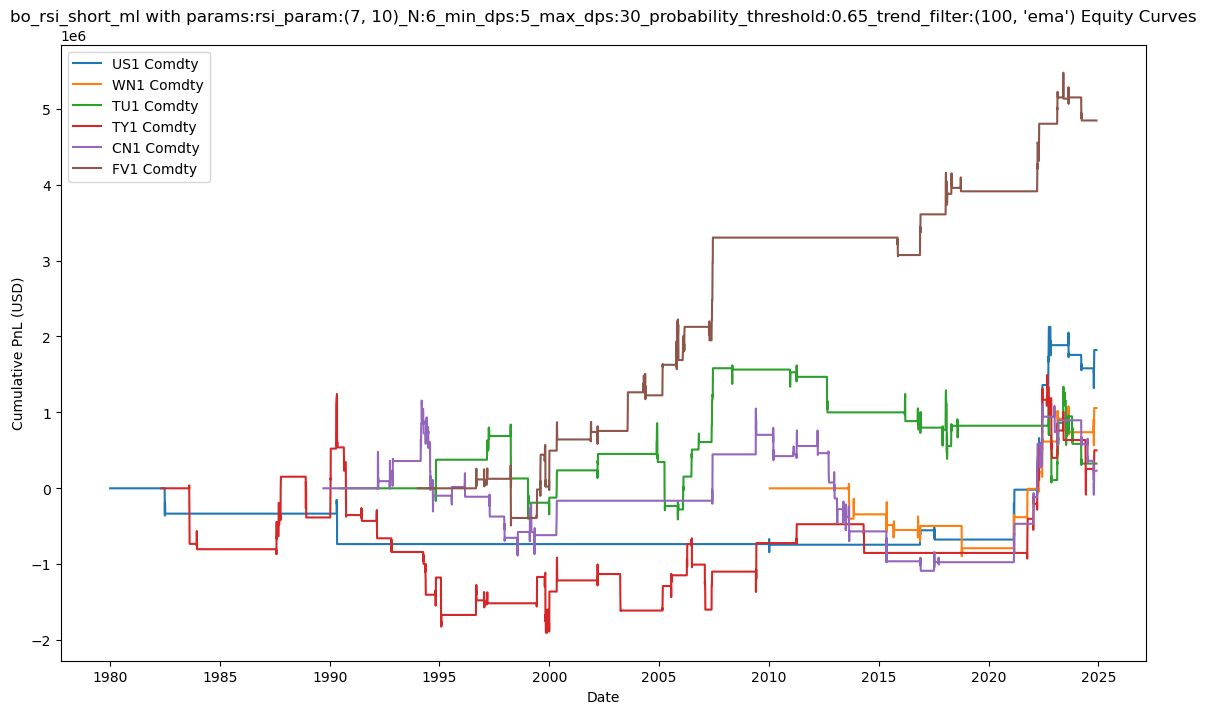

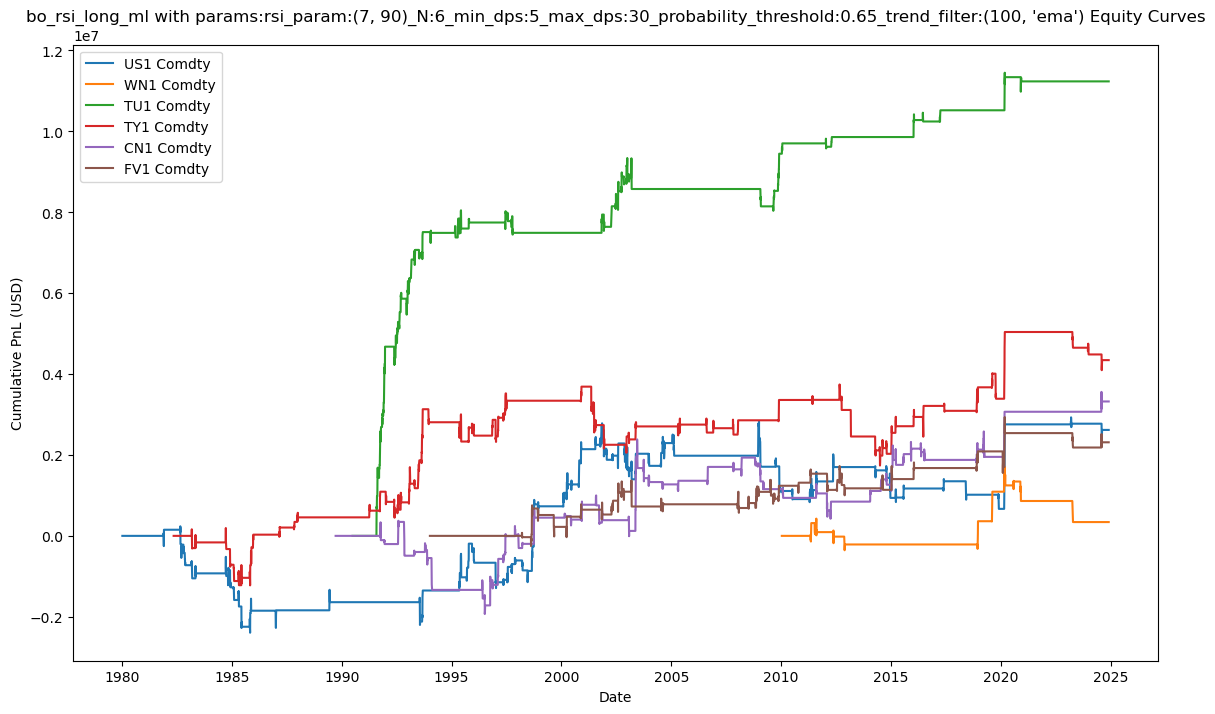

US1 Comdty  WN1 Comdty  TU1 Comdty  TY1 Comdty  CN1 Comdty  \
Date                                                                     
1980-01-02         NaN         NaN         NaN         NaN         NaN   
1980-01-03        0.00         NaN         NaN         NaN         NaN   
1980-01-04        0.00         NaN         NaN         NaN         NaN   
1980-01-07        0.00         NaN         NaN         NaN         NaN   
1980-01-08        0.00         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2024-11-26   2,619,156     341,000  11,235,680   4,344,641   3,322,553   
2024-11-27   2,619,156     341,000  11,235,680   4,344,641   3,322,553   
2024-11-28   2,619,156     341,000  11,235,680   4,344,641   3,322,553   
2024-11-29   2,619,156     341,000  11,235,680   4,344,641   3,322,553   
2024-12-02   2,619,156     341,000  11,235,680   4,344,641   3,322,553   

            FV1 Comdty      Total  
Date                               
1980-01-02         NaN       0.00  
1980-01-03         NaN       0.00  
1980-01-04         NaN       0.00  
1980-01-07         NaN       0.00  
1980-01-08         NaN       0.00  
...                ...        ...  
2024-11-26   2,313,211 24,176,241  
2024-11-27   2,313,211 24,176,241  
2024-11-28   2,313,211 24,176,241  
2024-11-29   2,313,211 24,176,241  
2024-12-02   2,313,211 24,176,241  

[11500 rows x 7 columns]

In [155]:
ml_short.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fx-em'])
ml_short.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fi-us'])
ml_long.plot_equity(byassets=True, totalsys=False,filter_assets=asset_classes['fi-us'])

<Axes: xlabel='Date'>

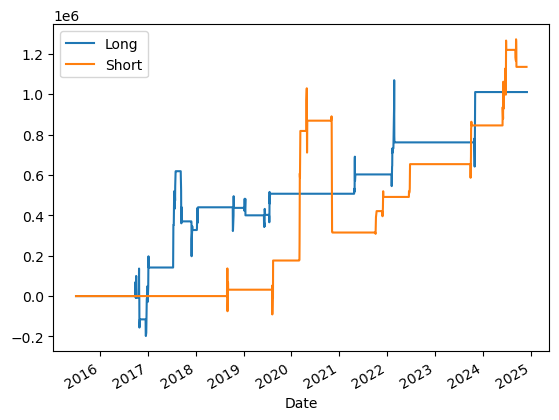

In [156]:
tck = 'BR1 Curncy'
tck_short_ml = ml_short.backtest_asset(tck,save=True)
tck_long_ml = ml_long.backtest_asset(tck,save=True)
tck_short_ml.set_index('Date', inplace=True)
tck_long_ml.set_index('Date', inplace=True)
tck_longshort = pd.DataFrame({'Long':tck_long_ml['Strategy_Equity_USD'],'Short':tck_short_ml['Strategy_Equity_USD']})
tck_longshort.plot()

In [157]:
tck_short_ml.to_clipboard()

In [158]:
tradeslist_s = ml_short._full_tradeslist()
tradeslist_l = ml_long._full_tradeslist()

tradeslist_s_tck = tradeslist_s[tradeslist_s['Asset'] == tck]
tradeslist_s_tck.to_clipboard()

In [159]:
tradeslist_s.tail(30).to_clipboard()

In [160]:
tradeslist_l.tail(30).to_clipboard()